In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.cluster import KMeans
import scipy.spatial.distance as dist
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


import warnings
warnings.filterwarnings(action="ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Loading the dataset

In [3]:
df = pd.read_csv('telecom_data.csv')
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311450e+19,4/4/19 12:01,770.0,4/25/19 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16457E+15,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311450e+19,4/9/19 13:04,235.0,4/25/19 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311450e+19,4/9/19 17:42,1.0,4/25/19 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311450e+19,4/10/19 0:31,486.0,4/25/19 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311450e+19,4/12/19 20:10,565.0,4/25/19 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [4]:
df.shape

(150001, 55)

# Pre-processing

Numerical, Categorical and TimeStamp features

In [5]:
numerical = []
categorical = []
timestamps = []

for col in df.columns:
    if df[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical.append(col)
    elif df[col].dtype == object:
        categorical.append(col)
    else:
        timestamps.append(col)
        
        
features = numerical+categorical+timestamps
data = df[features]
data.head(3)

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),Start,End,Last Location Name,Handset Manufacturer,Handset Type
0,1.311450e+19,770.0,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,42.0,5.0,23.0,...,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0,4/4/19 12:01,4/25/19 14:35,9.16457E+15,Samsung,Samsung Galaxy A5 Sm-A520F
1,1.311450e+19,235.0,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,65.0,5.0,16.0,...,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0,4/9/19 13:04,4/25/19 8:15,L77566A,Samsung,Samsung Galaxy J5 (Sm-J530)
2,1.311450e+19,1.0,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,NaN,NaN,6.0,...,395630.0,410692588.0,4215763.0,27883638.0,279807335.0,4/9/19 17:42,4/25/19 11:58,D42335A,Samsung,Samsung Galaxy A8 (2018)


In [6]:
data.dtypes

Bearer Id                                   float64
Start ms                                    float64
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mbps (%)                          float64
UL TP < 10 Kbps (%)                         float64
10 Kbps < UL TP < 50 Kbps (%)               float64
50 Kbps < UL

# Handling Null Values

Numerical Cols

In [7]:
#Null numerical values (percentage)
null = data[numerical].isna().sum().sort_values(ascending = False)
null_per = (null/150001) * 100
null_perc = pd.DataFrame(null_per)
null_perc

,0
Nb of sec with 37500B < Vol UL,86.835421
Nb of sec with 6250B < Vol UL < 37500B,74.561503
Nb of sec with 125000B < Vol DL,65.024900
TCP UL Retrans. Vol (Bytes),64.432237
Nb of sec with 31250B < Vol DL < 125000B,62.390251
Nb of sec with 1250B < Vol UL < 6250B,61.928920
Nb of sec with 6250B < Vol DL < 31250B,58.877607
TCP DL Retrans. Vol (Bytes),58.763608
HTTP UL (Bytes),54.539636
HTTP DL (Bytes),54.315638


Some columns have big percentages of missing values. For the meantime, imputation with column means will be done incase the columns come in handy. Otherwise, they'll be dropped. The big_data list below will store the names of cols with missing values > 50%

In [8]:
# columns with >50% null values

bad_data = []
for entry, column in zip(null_perc.iloc[:, 0], null_perc.index):
    if entry >= 50:
        bad_data.append(column)

All the numerical columns with missing values will be imputed with the mean of the column given the absence of nominal columns.

In [9]:
# get the numerical null values indices from the dataframe

a = null_perc.index.to_list()

# col_index = pd.DataFrame(raw.columns, columns = ['name'])
indices = []
for col in a:
    k = data.columns.get_loc(col)
    indices.append(k)
# col_index
len(indices)

50

In [10]:
data.columns.get_loc('MSISDN/Number')

5

In [11]:
indices.remove(5)
len(indices)

49

In [12]:
#imputing with column means.

columns = indices
for col in columns:
    x = data.iloc[:, col].values
    x = x.reshape(-1,1)
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit(x)
    x = imputer.transform(x)
    data.iloc[:, col] = x    

In [13]:
data[numerical].isna().any()

Bearer Id                                   False
Start ms                                    False
End ms                                      False
Dur. (ms)                                   False
IMSI                                        False
MSISDN/Number                                True
IMEI                                        False
Avg RTT DL (ms)                             False
Avg RTT UL (ms)                             False
Avg Bearer TP DL (kbps)                     False
Avg Bearer TP UL (kbps)                     False
TCP DL Retrans. Vol (Bytes)                 False
TCP UL Retrans. Vol (Bytes)                 False
DL TP < 50 Kbps (%)                         False
50 Kbps < DL TP < 250 Kbps (%)              False
250 Kbps < DL TP < 1 Mbps (%)               False
DL TP > 1 Mbps (%)                          False
UL TP < 10 Kbps (%)                         False
10 Kbps < UL TP < 50 Kbps (%)               False
50 Kbps < UL TP < 300 Kbps (%)              False


Categorical and Timestamp cols

In [14]:
#Null categorical and timestamps values

null = data[categorical + timestamps].isna().sum().sort_values(ascending = False)
null = (null/150001) * 100
null = pd.DataFrame(null)
null

,0
Last Location Name,0.768662
Handset Manufacturer,0.381331
Handset Type,0.381331
Start,0.000667
End,0.000667


The null values in these columns contribute a small percentage to the column values, thus not a big deal. Imputation will be done using the mode/most_frequent value. But first, they have to be converted to type str.

In [15]:
for col in categorical+timestamps:
    data[col] = data[col].astype(str)

In [16]:
# get the numerical null values indices from the dataframe
a = null.index.to_list()

# col_index = pd.DataFrame(raw.columns, columns = ['name'])
indices = []
for col in a:
    k = data.columns.get_loc(col)
    indices.append(k)
    
indices

[52, 53, 54, 50, 51]

In [17]:
# imputing with mode
indices.append(4) #the user id col
columns = indices
for col in columns:
    x = data.iloc[:, col].values
    x = x.reshape(-1,1)
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer = imputer.fit(x)
    x = imputer.transform(x)
    data.iloc[:, col] = x  

In [18]:
data[categorical+timestamps].isna().any()

Start                   False
End                     False
Last Location Name      False
Handset Manufacturer    False
Handset Type            False
dtype: bool

All null values taken care of.

# Timestamps to Pandas Datetime object

For imputation to work, their data type had to be change to string. That has to be reversed.

In [19]:
data['Start'] = pd.to_datetime(data['Start'])
data['End'] = pd.to_datetime(data['End'])

# Feature Generation

In [20]:
data['total_bytes'] =  data['Total UL (Bytes)'] + data['Total DL (Bytes)']
data['social_media'] = data['Social Media DL (Bytes)'] + data['Social Media UL (Bytes)']
data['email'] = data['Email DL (Bytes)'] + data['Email UL (Bytes)']
data['google'] = data['Google DL (Bytes)'] + data['Google UL (Bytes)']
data['youtube'] = data['Youtube DL (Bytes)'] + data['Youtube UL (Bytes)']
data['netflix'] = data['Netflix UL (Bytes)'] + data['Netflix DL (Bytes)']
data['gaming'] = data['Gaming DL (Bytes)'] + data['Gaming UL (Bytes)']
data['other'] = data['Other DL (Bytes)'] + data['Other UL (Bytes)']
data['total_tp'] = data['Avg Bearer TP DL (kbps)'] + data['Avg Bearer TP UL (kbps)']
data['total_rtt'] = data['Avg RTT DL (ms)'] + data['Avg RTT UL (ms)']
data['total_tcp'] = data['TCP DL Retrans. Vol (Bytes)'] + data['TCP UL Retrans. Vol (Bytes)']

Encoding Categorical columns

The method pd.get_dummies() encodes categorical variables using the OneHotEncoder method which is preferred over the LabelEncoder. The latter assigns numerical valuesm to the variable's values hierarchically. This will result to biased data since some entries could be perceived as having more weight than others when the only difference is class type. Despite the preference of OHE over LE, the dataset is already big, encoding it with OHE would increase it's size at least twice. Due to computational limitations (memory allocation), LE is used. But always, OHE is a better performer.

In [21]:
# enc_data = pd.get_dummies(data).reset_index(drop=True)
# enc_data.shape
data[categorical].head(3)

,Start,End,Last Location Name,Handset Manufacturer,Handset Type
0,2019-04-04 12:01:00,2019-04-25 14:35:00,9.16457E+15,Samsung,Samsung Galaxy A5 Sm-A520F
1,2019-04-09 13:04:00,2019-04-25 08:15:00,L77566A,Samsung,Samsung Galaxy J5 (Sm-J530)
2,2019-04-09 17:42:00,2019-04-25 11:58:00,D42335A,Samsung,Samsung Galaxy A8 (2018)


# Task- 1. User Overiew Analysis

Top 10 handsets

In [22]:
top_10_sets = data['Handset Type'].value_counts(ascending = False).head(10)
top_10_sets = pd.DataFrame(top_10_sets)
top_10_sets

,count
Handset Type,
Huawei B528S-23A,19752
Apple iPhone 6S (A1688),9419
Apple iPhone 6 (A1586),9023
undefined,8987
Apple iPhone 7 (A1778),6326
Apple iPhone Se (A1723),5187
Apple iPhone 8 (A1905),4993
Apple iPhone Xr (A2105),4568
Samsung Galaxy S8 (Sm-G950F),4520


Text(0.5, 1.0, 'A barplot indicating top ten handset types')

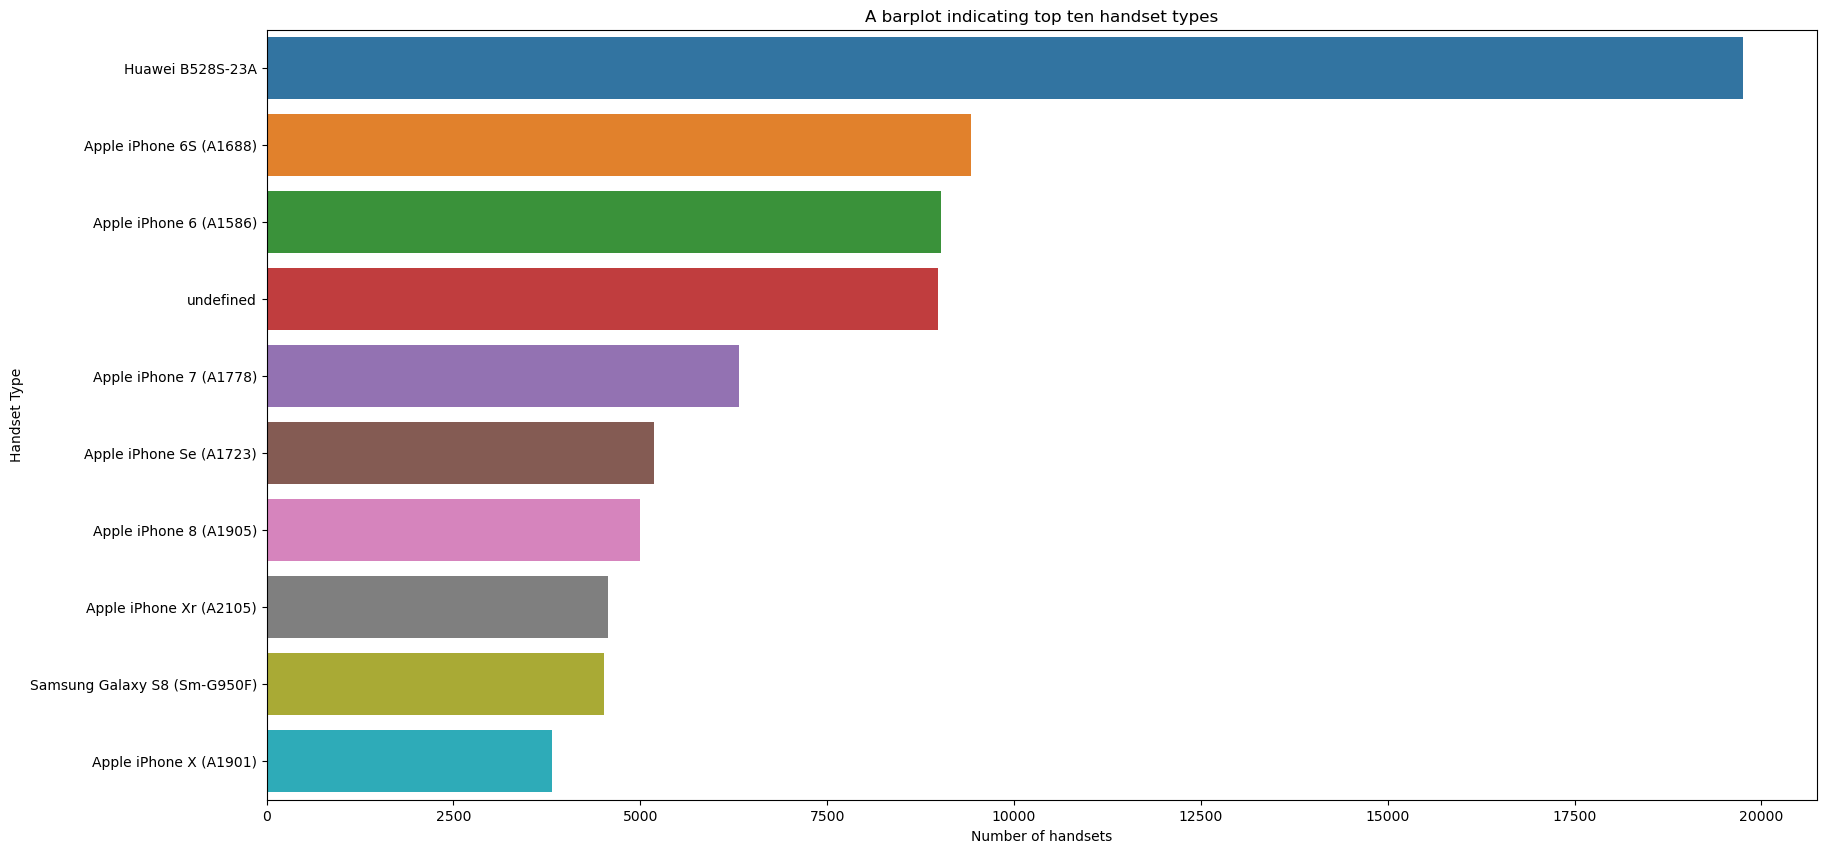

In [23]:
plt.figure(figsize=(20,10))
sns.barplot(y = top_10_sets.index, x = top_10_sets['count'])
plt.xlabel('Number of handsets')
plt.title('A barplot indicating top ten handset types')

top 3 handset manufacturers

In [24]:
top_3_manufacturers = data['Handset Manufacturer'].value_counts(ascending = False).head(3)
top_3_manufacturers = pd.DataFrame(top_3_manufacturers)
top_3_manufacturers

,count
Handset Manufacturer,
Apple,59565
Samsung,40839
Huawei,34423


Text(0.5, 1.0, 'A barplot indicating top 3 handset manufacturers')

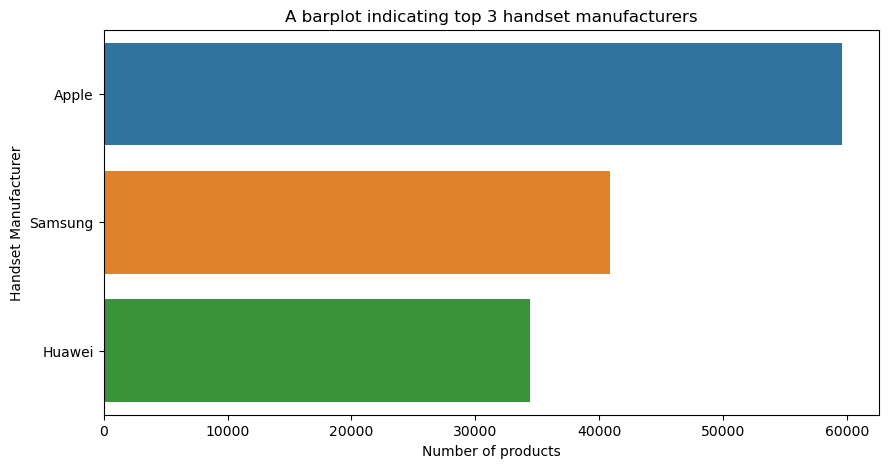

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(y = top_3_manufacturers.index, x = top_3_manufacturers['count'])
plt.xlabel('Number of products')
plt.title('A barplot indicating top 3 handset manufacturers')

top 5 handsets per handset manufacturer¶

In [26]:
a = data.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name = 'count').sort_values(['Handset Manufacturer', 'count'], ascending = False).groupby('Handset Manufacturer').head(5)
a.tail(20)

,Handset Manufacturer,Handset Type,count
66,Apple,Apple iPhone 7 (A1778),6326
80,Apple,Apple iPhone Se (A1723),5187
73,Apple,Apple iPhone 8 (A1905),4993
24,Alif Communications,Alif Communicati. Pulian Cm84,1
23,Adar,Adar Stanley Mobile S231,1
20,Acer,Acer M310,5
19,Acer,Acer Liquid Zest Plus,2
14,Acer,Acer Liquid M220,1
15,Acer,Acer Liquid Z220,1
16,Acer,Acer Liquid Z530,1


Making a short interpretation and recommendation to marketing teams

Apple, Huawei and Samsung are the leading manufacturers. The top 10 handsets also are manufactured by these companies. Some of the bottom 10 handsets also belong to these manufacturers. Thus the volume of the most common handsets should be increased to replace the least common sets.

Products from the bottom 3 manufacturers should no longer be stocked. Their extremely small volume matches small profit percentage in comparison to other manufacturers.

# Aggregate per user the following information in the column:

1. number of xDR sessions

In [27]:
xdr_sess = data[['Bearer Id', 'MSISDN/Number']]
a = xdr_sess.groupby('MSISDN/Number').count()
a.columns = ['xdr sessions']
a.head()

,xdr sessions
MSISDN/Number,
3.360100e+10,1
3.360100e+10,1
3.360100e+10,1
3.360101e+10,1
3.360101e+10,2


Text(0.5, 1.0, 'users with highest session numbers')

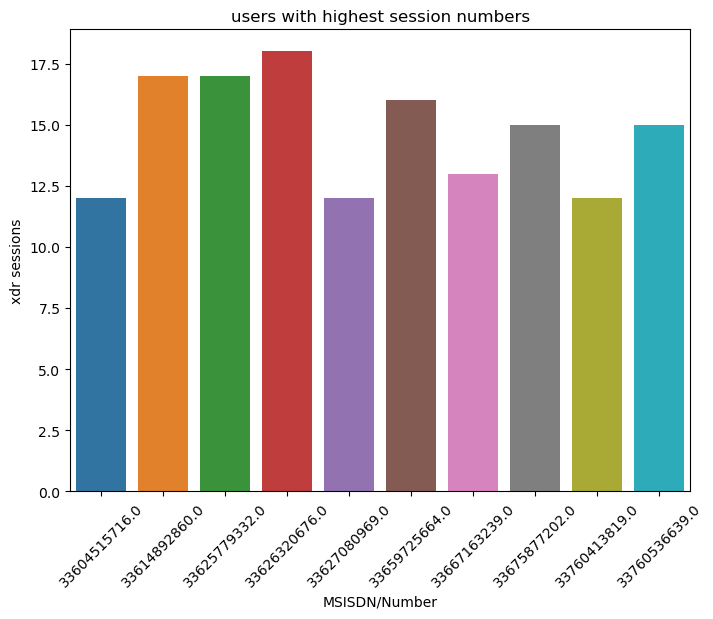

In [28]:
t = a.sort_values(by = 'xdr sessions', ascending = False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x = t.index, y = t['xdr sessions'])
plt.xticks(rotation = 45)
plt.title('users with highest session numbers')

2. Session duration

In [29]:
duration = data[['Dur. (ms)', 'MSISDN/Number']]
b = duration.groupby('MSISDN/Number').sum()
b.columns = ['sess_duration (ms)']
b.head()

,sess_duration (ms)
MSISDN/Number,
3.360100e+10,116720.0
3.360100e+10,181230.0
3.360100e+10,134969.0
3.360101e+10,49878.0
3.360101e+10,37104.0


Text(0.5, 1.0, 'users with longest session duration')

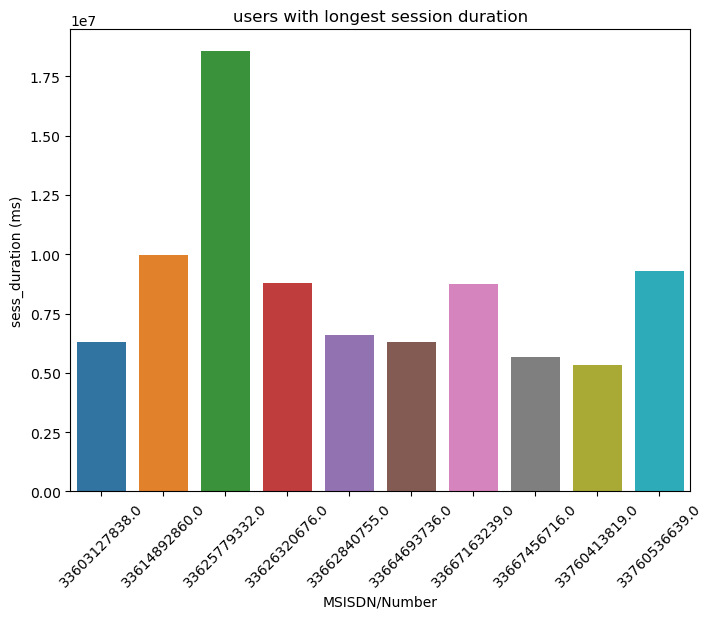

In [30]:
t = b.sort_values(by = 'sess_duration (ms)', ascending = False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x = t.index, y = t['sess_duration (ms)'])
plt.xticks(rotation = 45)
plt.title('users with longest session duration')

3. The total download (DL) and upload (UL) data

In [31]:
byte = data[['MSISDN/Number', 'Total UL (Bytes)', 'Total DL (Bytes)', 'total_bytes']]
c = byte.groupby('MSISDN/Number').sum()
c.head()

,Total UL (Bytes),Total DL (Bytes),total_bytes
MSISDN/Number,,,
3.360100e+10,36053108.0,8.426375e+08,8.786906e+08
3.360100e+10,36104459.0,1.207552e+08,1.568596e+08
3.360100e+10,39306820.0,5.566597e+08,5.959665e+08
3.360101e+10,20327526.0,4.019932e+08,4.223207e+08
3.360101e+10,94280527.0,1.363130e+09,1.457411e+09


Text(0.5, 1.0, 'A sample of users upload, download and total bytes')

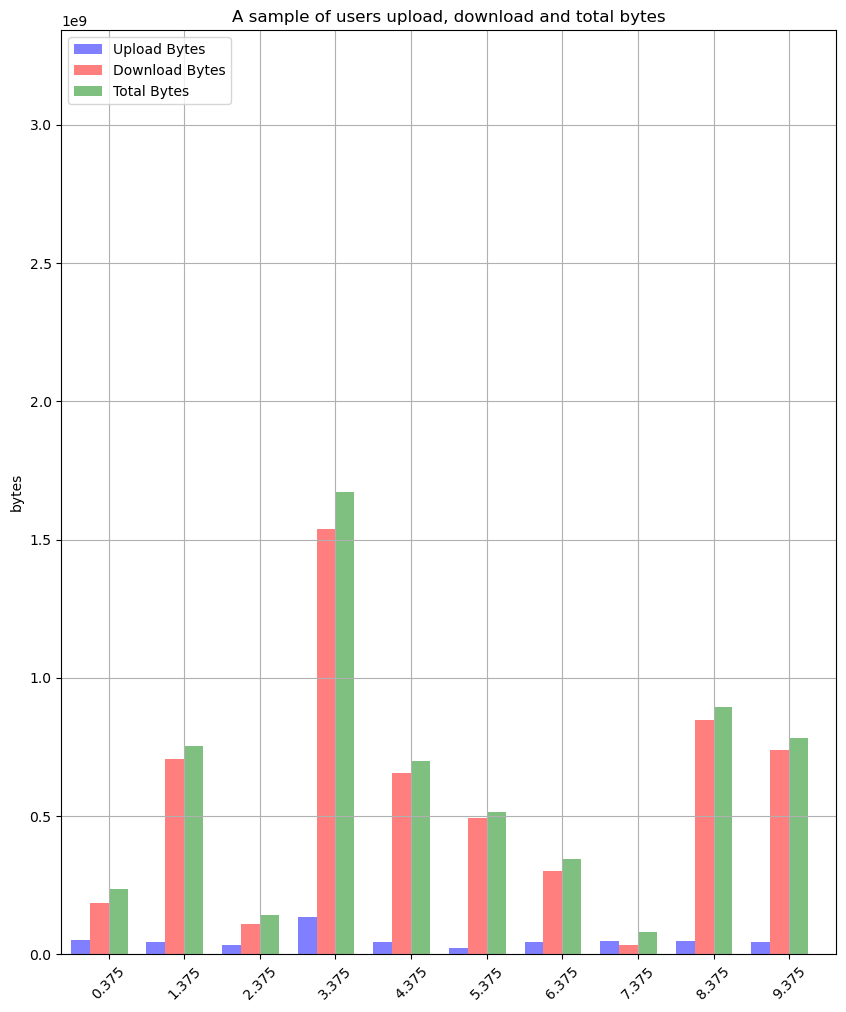

In [32]:
# plotting a sample of the data
t = c.sample(10)
pos = list(range(len(t['Total UL (Bytes)'])))
width = 0.25
fig, ax = plt.subplots(figsize=(10,12))
plt.bar(pos, t['Total UL (Bytes)'], width, alpha=0.5, color='b')
plt.bar([p + width for p in pos], t['Total DL (Bytes)'], width, alpha=0.5, color='r')
plt.bar([p + width*2 for p in pos], t['total_bytes'], width, alpha=0.5, color='g')
ax.set_ylabel('bytes')
ax.set_title('Bytes data per user')
ax.set_xticks([p + 1.5 * width for p in pos])
plt.xticks(rotation = 45)

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(t['Total UL (Bytes)'] + t['Total DL (Bytes)'] + t['total_bytes'])] )
plt.legend(['Upload Bytes', 'Download Bytes', 'Total Bytes'], loc='upper left')
plt.grid()
plt.title('A sample of users upload, download and total bytes')

Upload bytes are less than download bytes throughout.

The total data volume (in Bytes) during this session for each application

In [33]:
# I had already created total bytes columns for all the applications.
apps = data[['MSISDN/Number','social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'other']]
d = apps.groupby('MSISDN/Number').sum()
d.head()

,social_media,google,email,youtube,netflix,gaming,other
MSISDN/Number,,,,,,,
3.360100e+10,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08,386570872.0
3.360100e+10,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08,281710071.0
3.360100e+10,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08,501693672.0
3.360101e+10,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08,35279702.0
3.360101e+10,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09,804804484.0


# Non-Graphical Univariate Analysis

Variables of interest: Number of xDR sessions, Session duration, the total download (DL) and upload (UL) data , the total data volume (in Bytes) during this session for each application (Social Media, Google, Email, YouTube, Netflix, Gaming).

Dispersion and Central Tendency

In [34]:
variables = data[['Bearer Id', 'Dur. (ms).1', 'Total UL (Bytes)', 'Total DL (Bytes)', 'social_media', 'netflix',
                  'gaming', 'youtube', 'google', 'email', 'other', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
                 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']]
variables.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Bearer Id,150001.0,1.013887e+19,2.883597e+18,6.917540e+18,7.349880e+18,7.349880e+18,1.304240e+19,1.318650e+19
Dur. (ms).1,150001.0,1.046091e+08,8.103734e+07,7.142988e+06,5.744206e+07,8.639998e+07,1.324307e+08,1.859336e+09
Total UL (Bytes),150001.0,4.112121e+07,1.127635e+07,2.866892e+06,3.322203e+07,4.114324e+07,4.903424e+07,7.833131e+07
Total DL (Bytes),150001.0,4.546434e+08,2.441421e+08,7.114041e+06,2.431072e+08,4.558409e+08,6.657051e+08,9.029696e+08
social_media,150001.0,1.828250e+06,1.035646e+06,1.563000e+03,9.322180e+05,1.826471e+06,2.727487e+06,3.650861e+06
netflix,150001.0,2.262861e+07,9.260820e+06,9.843200e+04,1.597946e+07,2.263554e+07,2.929044e+07,4.519815e+07
gaming,150001.0,4.303331e+08,2.440199e+08,3.063580e+05,2.187279e+08,4.316150e+08,6.414159e+08,8.592028e+08
youtube,150001.0,2.264348e+07,9.246800e+06,7.890300e+04,1.599846e+07,2.266177e+07,2.929260e+07,4.519008e+07
google,150001.0,7.807295e+06,3.516420e+06,4.033000e+04,4.943599e+06,7.812835e+06,1.068280e+07,1.552878e+07
email,150001.0,2.259102e+06,1.071109e+06,8.359000e+03,1.359344e+06,2.263567e+06,3.159818e+06,4.518036e+06


In [35]:
data['Bearer Id'].nunique()

10

In [36]:
# skewness and kurtosis
s = variables.skew(axis = 0, skipna = True) 
k = variables.kurt(axis = 0, skipna = True) 
pd.DataFrame([s, k], index = ['skewness', 'kurtosis'])

,Bearer Id,Dur. (ms).1,Total UL (Bytes),Total DL (Bytes),social_media,netflix,gaming,youtube,google,email,other,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
skewness,0.026755,3.952622,-0.002456,-0.003153,-0.002121,-0.000409,-0.003225,-0.005465,-0.010602,-0.006033,0.001256,69.705161,31.530109,2.589445,4.503428,24.840677,141.035684
kurtosis,-1.988473,37.022470,-0.327436,-1.198363,-1.202178,-0.608472,-1.202256,-0.604624,-0.963035,-1.061696,-1.196015,8805.687875,1632.646032,9.573691,25.086860,697.574773,21913.803296


Highly skewed distribution: If the skewness value is less than −1 or greater than +1.

Moderately skewed distribution: If the skewness value is between −1 and −½ or between +½ and +1.

Approximately symmetric distribution: If the skewness value is between −½ and +½.

Really Flat distribution: Kurtosis less than -1. Peaked distribution: Kurtosis more than 1.

# Outlier Detection

In [37]:
#IQR

#google
Q1 = np.percentile(data.google, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.google, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.google, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.google, interpolation = 'midpoint') 
o = (data.google < (Q1 - 1.5 * IQR)) |(data.google > (Q3 + 1.5 * IQR))
i = o.unique()

#youtube
Q1 = np.percentile(data.youtube, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.youtube, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.youtube, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.youtube, interpolation = 'midpoint') 
o = (data.youtube < (Q1 - 1.5 * IQR)) |(data.youtube > (Q3 + 1.5 * IQR))
j = o.unique()

#gaming
Q1 = np.percentile(data.gaming, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.gaming, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.gaming, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.gaming, interpolation = 'midpoint') 
o = (data.gaming < (Q1 - 1.5 * IQR)) |(data.gaming > (Q3 + 1.5 * IQR))
k = o.unique()


#netflix
Q1 = np.percentile(data.netflix, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.netflix, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.netflix, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.netflix, interpolation = 'midpoint') 
o = (data.netflix < (Q1 - 1.5 * IQR)) |(data.netflix > (Q3 + 1.5 * IQR))
l = o.unique()


#email
Q1 = np.percentile(data.email, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.email, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.email, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.email, interpolation = 'midpoint') 
o = (data.email < (Q1 - 1.5 * IQR)) |(data.email > (Q3 + 1.5 * IQR))
m = np.unique(o)


#social_media
Q1 = np.percentile(data.social_media, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.social_media, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.social_media, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.social_media, interpolation = 'midpoint') 
o = (data.social_media < (Q1 - 1.5 * IQR)) |(data.social_media > (Q3 + 1.5 * IQR))
n = o.unique()

#others
Q1 = np.percentile(data.other, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.other, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.other, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.other, interpolation = 'midpoint') 
o = (data.other < (Q1 - 1.5 * IQR)) |(data.other > (Q3 + 1.5 * IQR))
p = o.unique()




['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
                 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']
#Dur. (ms).1
Q1 = np.percentile(data['Dur. (ms).1'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(data['Dur. (ms).1'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(data['Dur. (ms).1'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(data['Dur. (ms).1'], interpolation = 'midpoint') 
o = (data['Dur. (ms).1'] < (Q1 - 1.5 * IQR)) |(data['Dur. (ms).1'] > (Q3 + 1.5 * IQR))
q = o.unique()

#total_bytes
Q1 = np.percentile(data.total_bytes, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.total_bytes, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.total_bytes, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.total_bytes, interpolation = 'midpoint') 
o = (data.total_bytes < (Q1 - 1.5 * IQR)) |(data.total_bytes > (Q3 + 1.5 * IQR))
r = o.unique()

#total_tp
Q1 = np.percentile(data.total_tp, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.total_tp, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.total_tp, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.total_tp, interpolation = 'midpoint') 
o = (data.total_tp < (Q1 - 1.5 * IQR)) |(data.total_tp > (Q3 + 1.5 * IQR))
s = o.unique()

#total_rtt
Q1 = np.percentile(data.total_rtt, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.total_rtt, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.total_rtt, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.total_rtt, interpolation = 'midpoint') 
o = (data.total_rtt < (Q1 - 1.5 * IQR)) |(data.total_rtt > (Q3 + 1.5 * IQR))
t = o.unique()

#total_tcp
Q1 = np.percentile(data.total_tcp, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.total_tcp, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.total_tcp, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.total_tcp, interpolation = 'midpoint') 
o = (data.total_tcp < (Q1 - 1.5 * IQR)) |(data.total_tcp > (Q3 + 1.5 * IQR))
u = o.unique()


print('google', i)
print('youtube', j)
print('gaming', k)
print('netflix', l)
print('email', m)
print('social media', n)
print('other', p)
print('Duration', q)
print('total bytes', r)
print('total_tp', s)
print('total_rtt', t)
print('total_tcp', u)

google [False]
youtube [False]
gaming [False]
netflix [False]
email [False]
social media [False]
other [False]
Duration [ True False]
total bytes [False]
total_tp [False  True]
total_rtt [False  True]
total_tcp [False  True]


No outliers present in the apps. Outliers present in the session duration, total throughput, total rtt* and *total tcp. This will be taken care of in a later section.

Same method will be extended to other columns.

# Graphical Univariate Analysis


 mu = 430333100.71 and sigma = 244019110.62



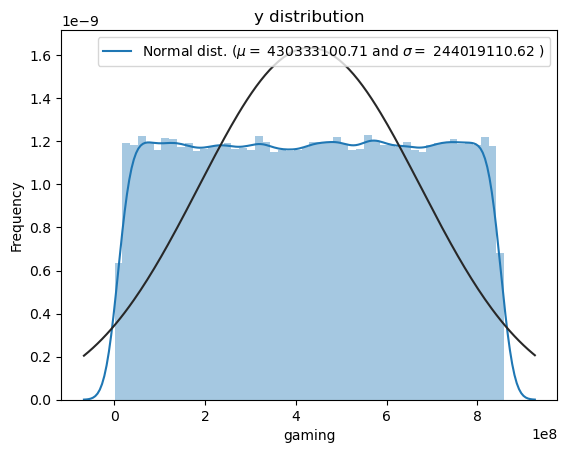

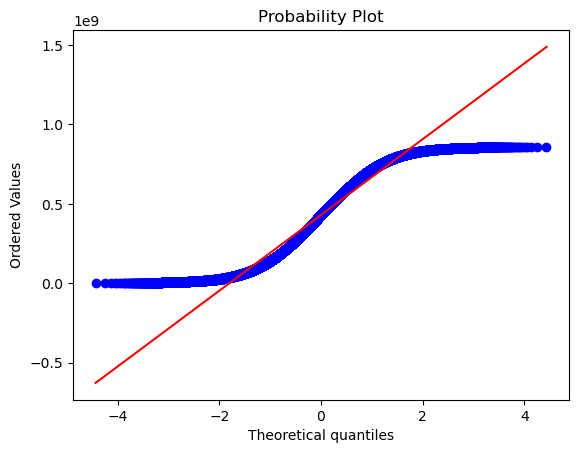

In [38]:
sns.distplot(data['gaming'] , fit=norm);

(mu, sigma) = norm.fit(data['gaming'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(data['gaming'], plot=plt)
plt.show()


 mu = 22628606.54 and sigma = 9260789.22



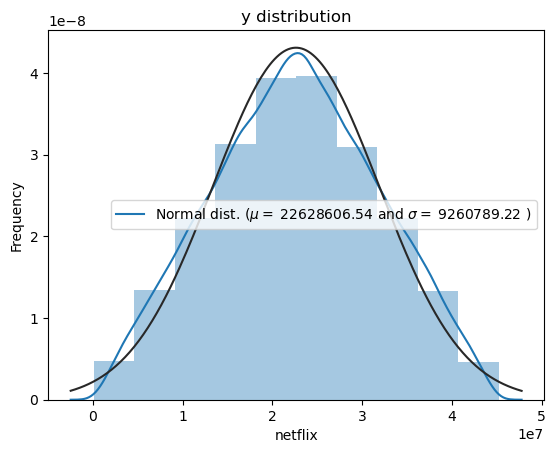

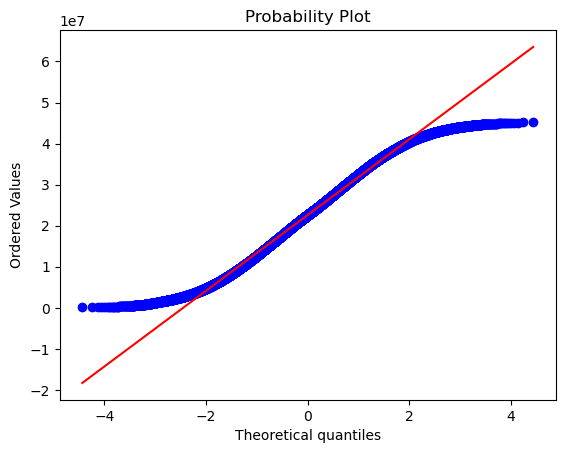

In [39]:
sns.distplot(data['netflix'] , bins = 10, fit=norm);

(mu, sigma) = norm.fit(data['netflix'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(data['netflix'], plot=plt)
plt.show()


 mu = 22643482.64 and sigma = 9246769.48



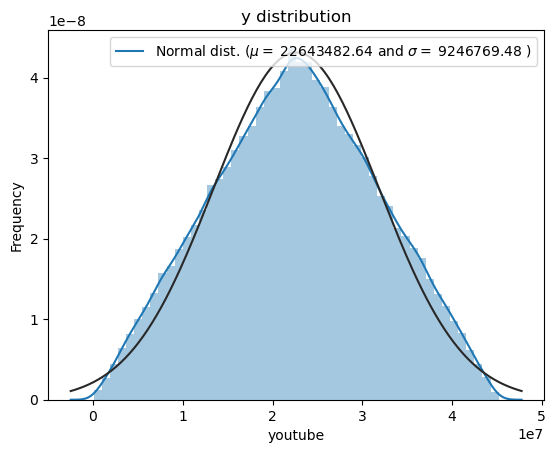

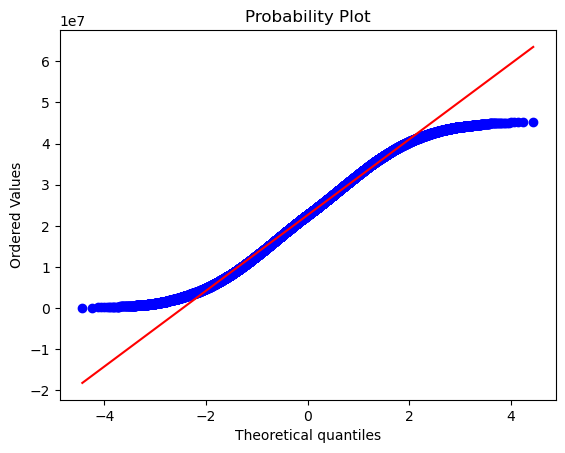

In [40]:
sns.distplot(data['youtube'] , fit=norm);

(mu, sigma) = norm.fit(data['youtube'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(data['youtube'], plot=plt)
plt.show()


 mu = 2259102.31 and sigma = 1071105.49



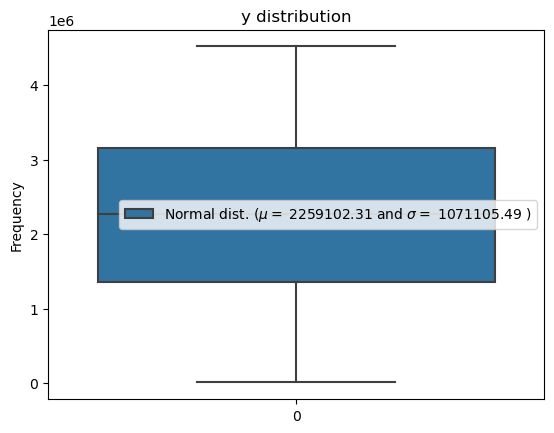

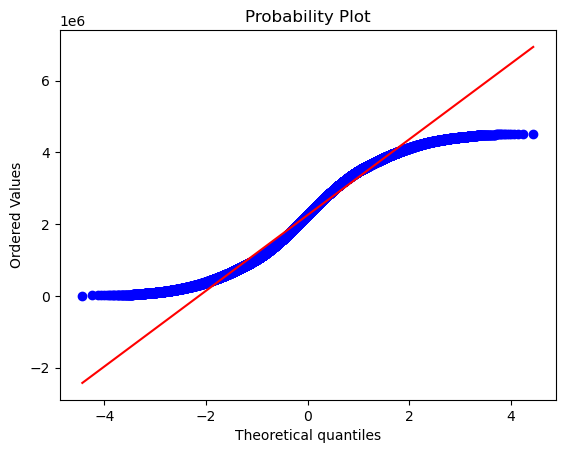

In [41]:
sns.boxplot(data['email'])

(mu, sigma) = norm.fit(data['email'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(data['email'], plot=plt)
plt.show()


 mu = 7807294.55 and sigma = 3516408.52



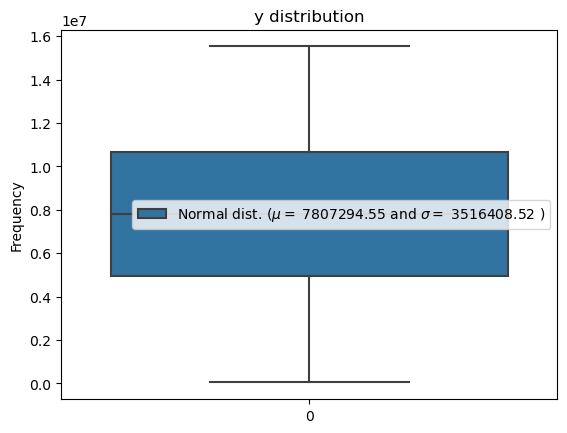

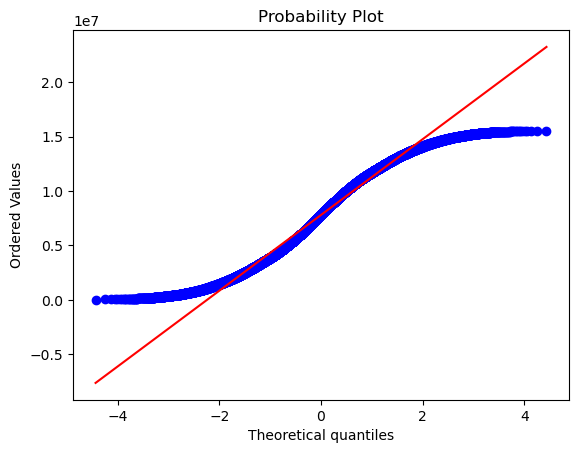

In [42]:
sns.boxplot(data['google'])

(mu, sigma) = norm.fit(data['google'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(data['google'], plot=plt)
plt.show()


 mu = 1828250.21 and sigma = 1035642.69



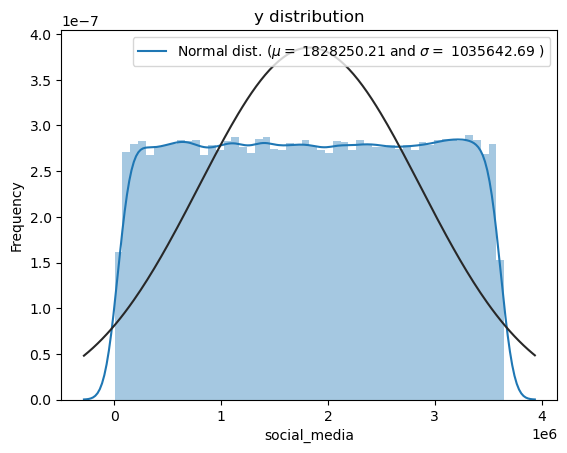

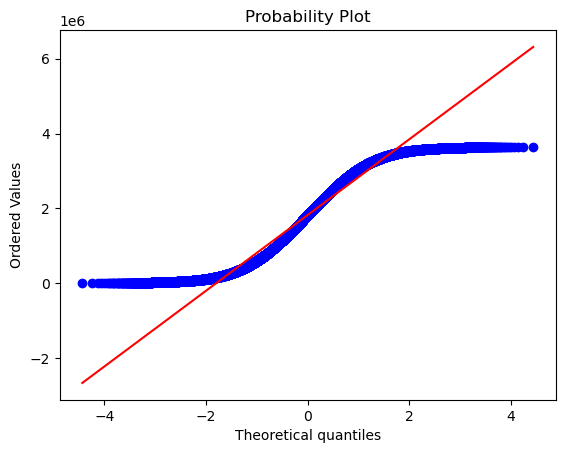

In [43]:
sns.distplot(data['social_media'] , fit=norm);

(mu, sigma) = norm.fit(data['social_media'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(data['social_media'], plot=plt)
plt.show()


 mu = 495764636.37 and sigma = 244380172.44



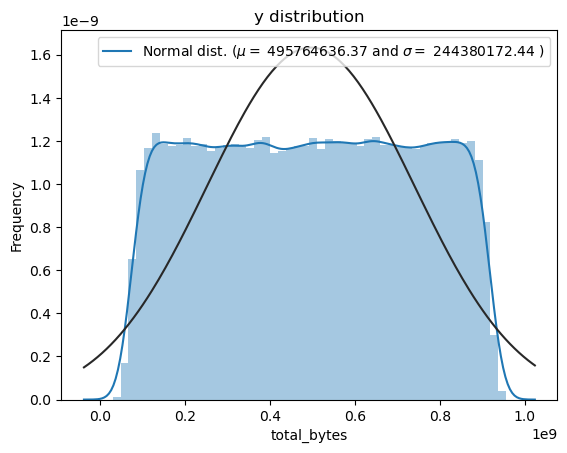

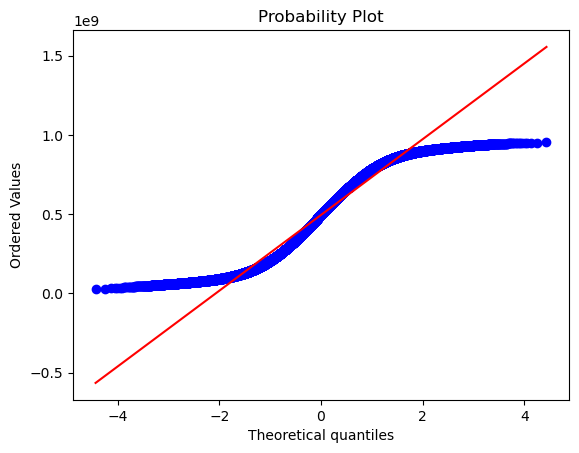

In [44]:
sns.distplot(data['total_bytes'] , fit=norm);

(mu, sigma) = norm.fit(data['total_bytes'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(data['total_bytes'], plot=plt)
plt.show()


 mu = 104609105.55 and sigma = 81037071.33



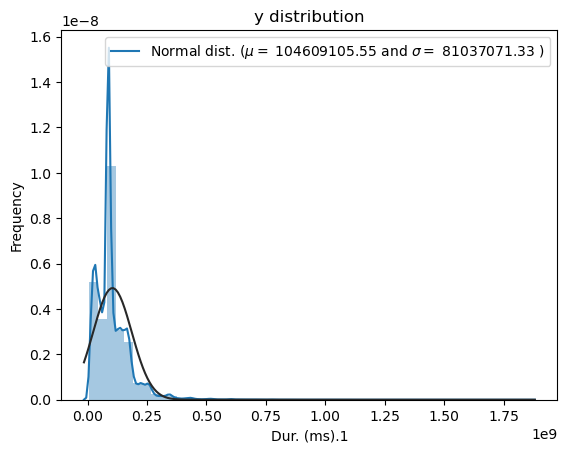

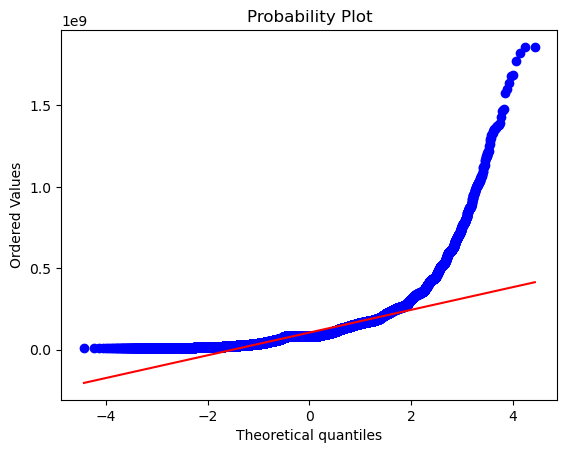

In [45]:
# xdr ms
sns.distplot(data['Dur. (ms).1'] , fit=norm);

(mu, sigma) = norm.fit(data['Dur. (ms).1'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(data['Dur. (ms).1'], plot=plt)
plt.show()

# Bivariate Analysis

explore the relationship between each application & the total DL+UL data using appropriate methods and interpret your findings.

In [46]:
biv_data = data[['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'total_bytes', 'other']]
# adding a summation row in all columns
biv_data.loc['totals'] = biv_data.sum()
biv_data.tail()

,social_media,google,email,youtube,netflix,gaming,total_bytes,other
149997,2.352181e+06,4.415361e+06,2.121718e+06,2.216552e+07,4.064329e+07,6.316281e+08,7.057839e+08,7.146381e+08
149998,1.260239e+06,6.585469e+06,2.058277e+06,2.451641e+07,1.502970e+07,5.669338e+08,6.276986e+08,1.324156e+08
149999,8.231090e+05,7.757267e+06,2.850914e+06,1.712251e+07,1.649484e+07,3.550664e+08,4.015220e+08,8.161200e+08
150000,1.828250e+06,7.807295e+06,2.259102e+06,2.264348e+07,2.262861e+07,4.303331e+08,4.957646e+08,4.293653e+08
totals,2.742394e+11,1.171102e+12,3.388676e+11,3.396545e+12,3.394314e+12,6.455040e+13,7.436519e+13,6.440523e+13


Applications total bytes

Text(0.5, 0, 'application')

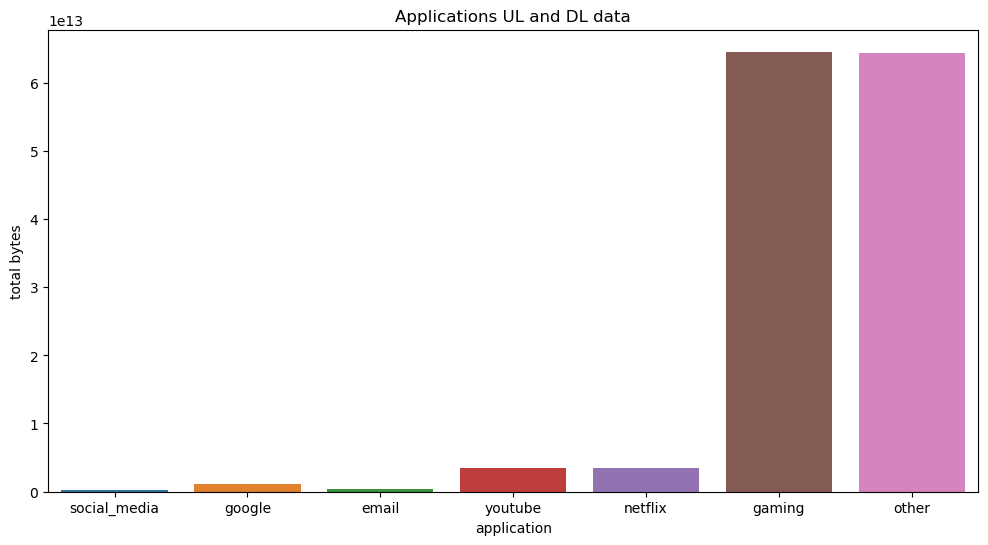

In [47]:
a = biv_data.tail(1)
long_df = pd.melt(a)
long_df = long_df.drop([6], axis  = 0)
plt.figure(figsize=(12,6))
sns.barplot(x = long_df.variable, y = long_df.value)
plt.title('Applications UL and DL data')
plt.ylabel('total bytes')
plt.xlabel('application')

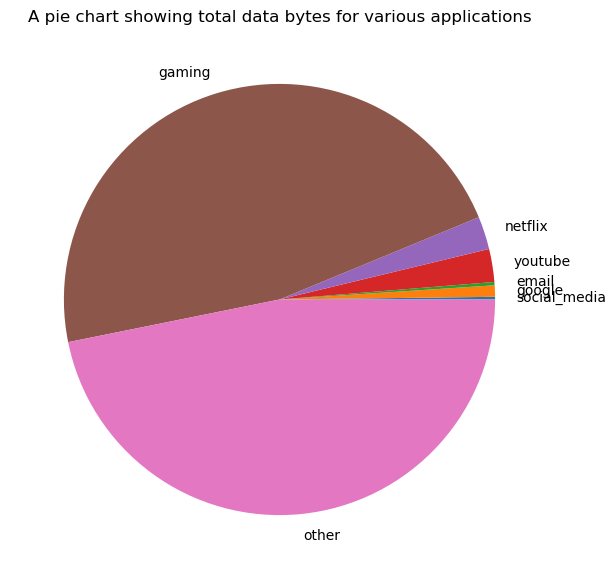

In [48]:
fig = plt.figure(figsize =(10, 7)) 
a = biv_data.drop(['total_bytes'], axis = 1)
plt.pie(a.loc['totals'], labels = a.columns)
plt.title('A pie chart showing total data bytes for various applications')
plt.show()

The large percentage of others can be explained by many applications under the name others.

As for gaming:

The applications are heavy. (Require more data)
Most of the users are gamers.
Most of the applications in the hand sets are games.

*One on one plots on the apps vs total_bytes*

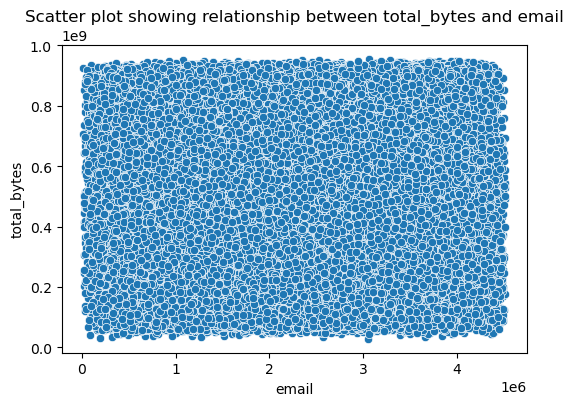

In [49]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data = data, x='email', y='total_bytes')
plt.title('Scatter plot showing relationship between total_bytes and email')
plt.show()

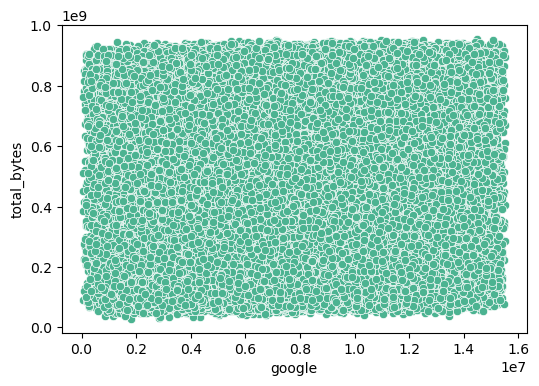

In [50]:
plt.figure(figsize=(6, 4))

sns.scatterplot(data = data, x='google', y='total_bytes', color = '#4CB391')

plt.show()

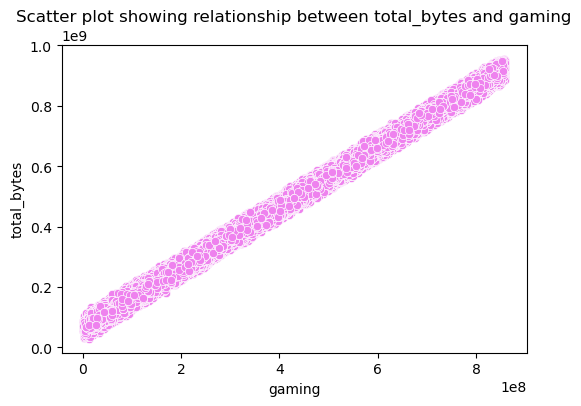

In [51]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data = data, x='gaming', y='total_bytes', color = 'violet')
plt.title('Scatter plot showing relationship between total_bytes and gaming')
plt.show()

# Variable transformations

segment the users into top five decile classes based on the total duration for all sessions and compute the total data (DL+UL) per decile class.

In [52]:
data['Decile_rank'] = pd.qcut(data['Dur. (ms).1'], 5, labels = False) 

In [53]:
new_df = data[['Decile_rank', 'total_bytes']]
a = new_df.groupby('Decile_rank').sum()
a

,total_bytes
Decile_rank,
0,1.488404e+13
1,1.492541e+13
2,1.478282e+13
3,1.485458e+13
4,1.491834e+13


Text(0.5, 0, 'decile rank')

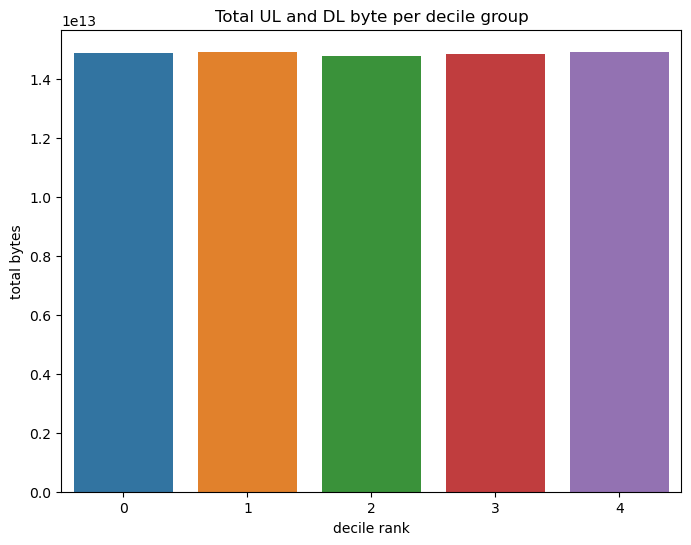

In [54]:
plt.figure(figsize=(8,6))
sns.barplot(x = a.index, y = a.total_bytes)
plt.title('Total UL and DL byte per decile group')
plt.ylabel('total bytes')
plt.xlabel('decile rank')

# Correlation Analysis

compute a correlation matrix for the following variables and interpret your findings: Social Media data, Google data, Email data, Youtube data, Netflix data, Gaming data, Other data - (jupyter notebook + slide )

correlation on the total bytes

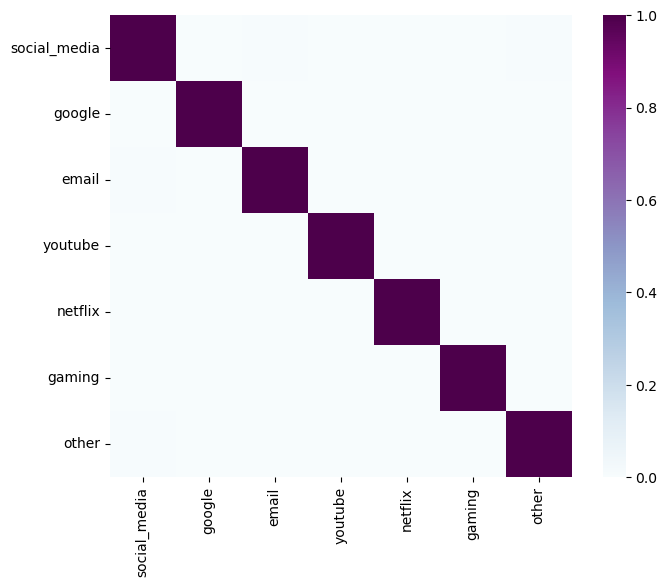

In [55]:
corr_data = data[['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'other']]

    
corr = corr_data.corr()
f_fig, f_ax = plt.subplots(figsize=(8, 6))
f_ax = sns.heatmap(corr, vmin=0, vmax=1, square=True,
                   annot=False, annot_kws={"size": 10}, cmap="BuPu")

The correlation between the variables is super low.

# Dimensionality Reduction

perform a principal component analysis to reduce the dimensions of your data and provide a useful interpretation of the results.

In [56]:
from sklearn.preprocessing import StandardScaler

new_numerical = []
for col in data.columns:
    if data[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        new_numerical.append(col)
        
seg = data[new_numerical].copy()
seg = seg.drop(['MSISDN/Number'], axis = 1) #drop the id col
scaler = StandardScaler()
scaled_data = scaler.fit_transform(seg)

In [57]:
scaled_data.shape

(150001, 61)

In [58]:
pca = PCA()
pca.fit(scaled_data)

PCA()

In [59]:
pca.explained_variance_ratio_

array([1.32492382e-01, 6.55594537e-02, 5.33988157e-02, 4.72192852e-02,
       4.17741797e-02, 3.58367943e-02, 3.33932627e-02, 3.30774484e-02,
       3.28873831e-02, 3.27786919e-02, 3.25874808e-02, 3.23445629e-02,
       2.97616370e-02, 2.73093776e-02, 2.44971737e-02, 2.38808638e-02,
       2.28917515e-02, 1.83805146e-02, 1.74473732e-02, 1.65521252e-02,
       1.65074033e-02, 1.64178617e-02, 1.63859354e-02, 1.63656184e-02,
       1.62756077e-02, 1.62291920e-02, 1.59436181e-02, 1.57855073e-02,
       1.49907398e-02, 1.43950667e-02, 1.22888325e-02, 1.19835824e-02,
       1.01762140e-02, 8.71470644e-03, 7.99183306e-03, 6.94595944e-03,
       6.18335611e-03, 4.97509202e-03, 4.72650521e-03, 4.49260919e-03,
       2.89766576e-03, 2.54089939e-03, 1.32429246e-03, 1.04470640e-03,
       2.68184892e-04, 6.36313474e-05, 1.48216571e-05, 1.22896685e-13,
       3.35713488e-17, 3.04880102e-17, 1.83500123e-17, 8.95257735e-18,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

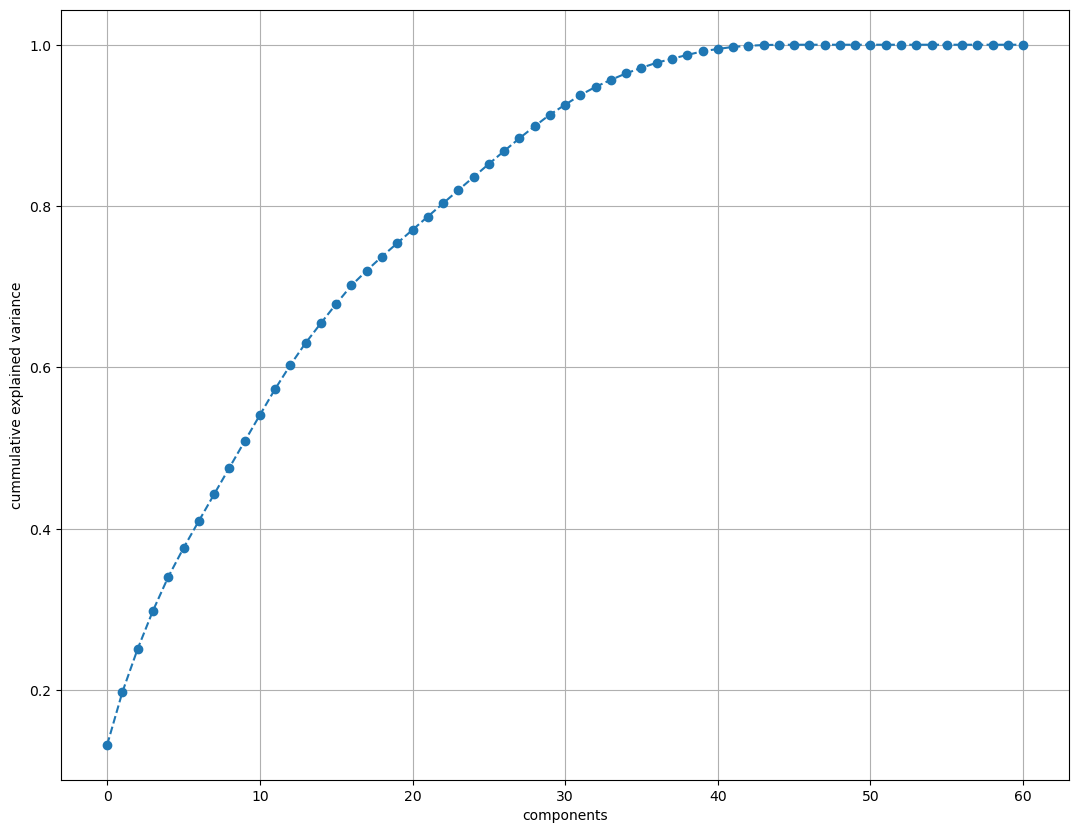

In [60]:
plt.figure(figsize = (13,10))
plt.plot(range(61), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('components')
plt.ylabel('cummulative explained variance')
plt.grid(True)

When choosing the number of components, the number cutting at least 80% of the cumm explained variance is considered. n = 23

In [61]:
pca = PCA(n_components = 23)
pca.fit(scaled_data)

PCA(n_components=23)

In [62]:
pca_scores = pca.transform(scaled_data)

In [63]:
a = pd.DataFrame(pca_scores)
a['MSISDN/Number'] = data['MSISDN/Number']
a.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,MSISDN/Number
0,-4.185039,-1.301016,16.570781,8.694181,-0.393979,-12.999922,-1.469147,-0.678097,1.353584,-1.226194,...,-1.469485,-0.599700,-0.284400,0.996299,-0.342624,0.067688,0.429784,0.396596,-0.443533,3.366496e+10
1,-3.395571,1.615078,12.343656,6.452705,3.441611,-9.403602,0.295607,0.322013,-1.494965,-2.036713,...,-0.942008,1.268810,-0.275830,-0.299164,-0.047788,-1.781786,0.491235,-1.170276,0.657133,3.368185e+10
2,-3.409947,-1.598248,12.354045,6.429606,0.399677,-9.482374,0.182622,-0.112064,0.490237,1.391436,...,-0.821759,2.698816,-0.362222,-0.854596,0.016884,-0.254022,-0.235684,-0.391586,-0.147218,3.376063e+10
3,-3.375223,3.127615,12.029785,6.281262,0.982951,-9.142835,1.564100,0.283573,-2.348264,1.895168,...,-1.005548,0.377972,-0.243749,-0.763291,0.094850,0.514182,-0.060492,-0.549228,0.555594,3.375034e+10
4,-2.977236,0.829894,9.902161,5.127507,0.558089,-7.422093,0.829889,0.010221,-1.567311,0.313497,...,-0.694376,0.818612,-0.200114,1.361381,0.061937,-1.405442,-1.566345,-0.445702,-1.262347,3.369980e+10


<Axes: xlabel='0', ylabel='1'>

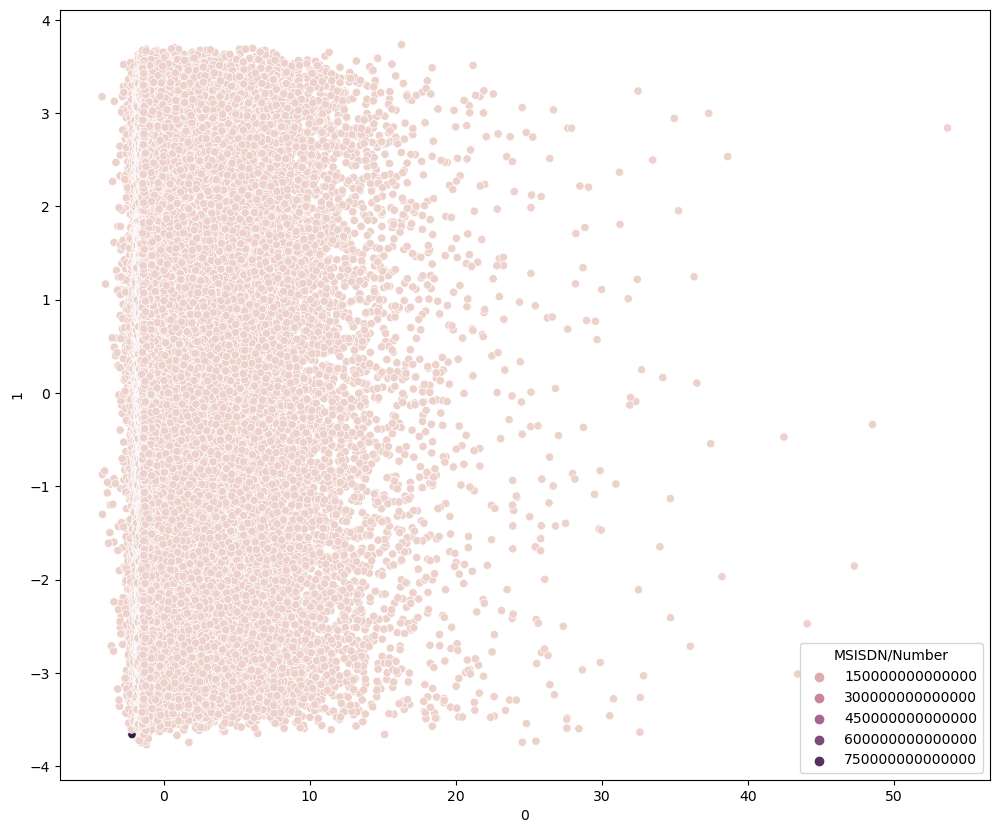

In [64]:
plt.figure(figsize=(12,10))
sns.scatterplot(x= a[0], y = a[1], hue = a['MSISDN/Number'])

# Task- 2. User Engagement Analysis

In the current dataset we are going to track the user’s engagement using the following engagement metrics:

sessions frequency

the duration of the session

the sessions total traffic (download and upload (bytes))

# Sessions frequency, sessions duration, sessions total traffic.

In [65]:
user_data = data[['MSISDN/Number', 'total_bytes', 'Dur. (ms).1', 'Bearer Id']]

In [66]:
agg_user_data = user_data.groupby('MSISDN/Number').agg({'Bearer Id':'count', 'Dur. (ms).1':'sum',  'total_bytes': 'sum'})
agg_user_data.columns = ['sessions_freq', 'sessions_duration(ms)', 'sessions_traffic(bytes)']
agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes)
MSISDN/Number,,,
3.360100e+10,1,116720140.0,8.786906e+08
3.360100e+10,1,181230963.0,1.568596e+08
3.360100e+10,1,134969374.0,5.959665e+08
3.360101e+10,1,49878024.0,4.223207e+08
3.360101e+10,2,37104453.0,1.457411e+09


# Top 10 users with high sessions frequency

Text(0.5, 1.0, 'a barplot indicating 10 users with highest number of sessions')

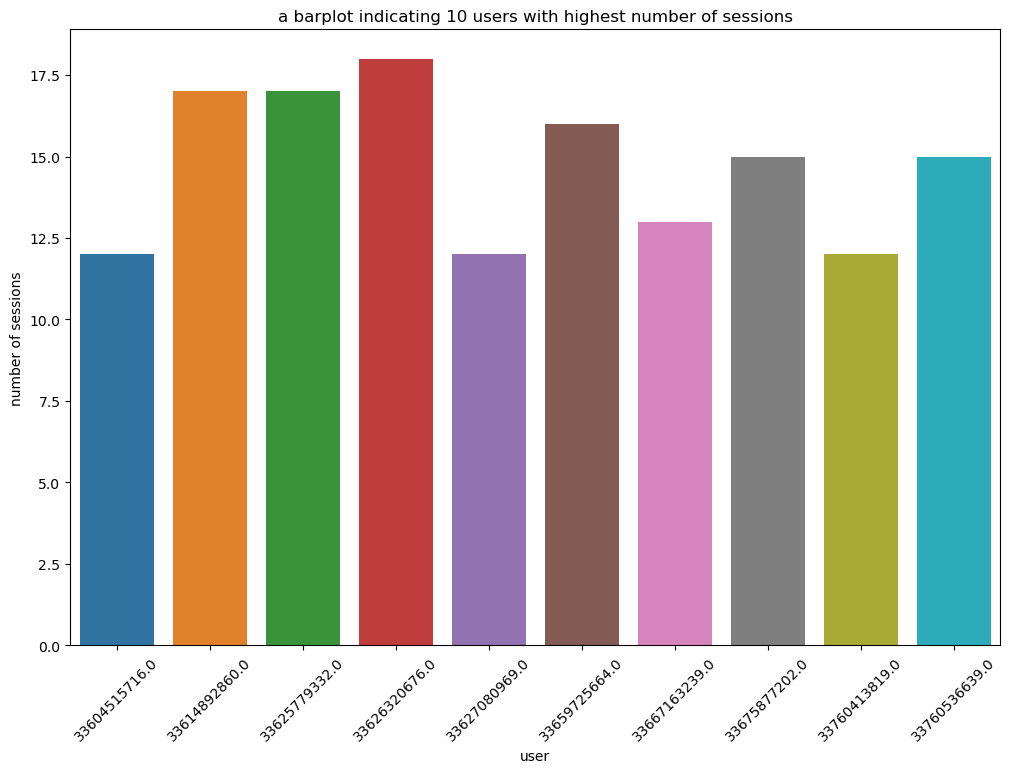

In [67]:
a = agg_user_data.sort_values(by = 'sessions_freq', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = a.index, y = a['sessions_freq'])
plt.ylabel('number of sessions')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest number of sessions')

# Top 10 users with high sessions traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest sessions traffic')

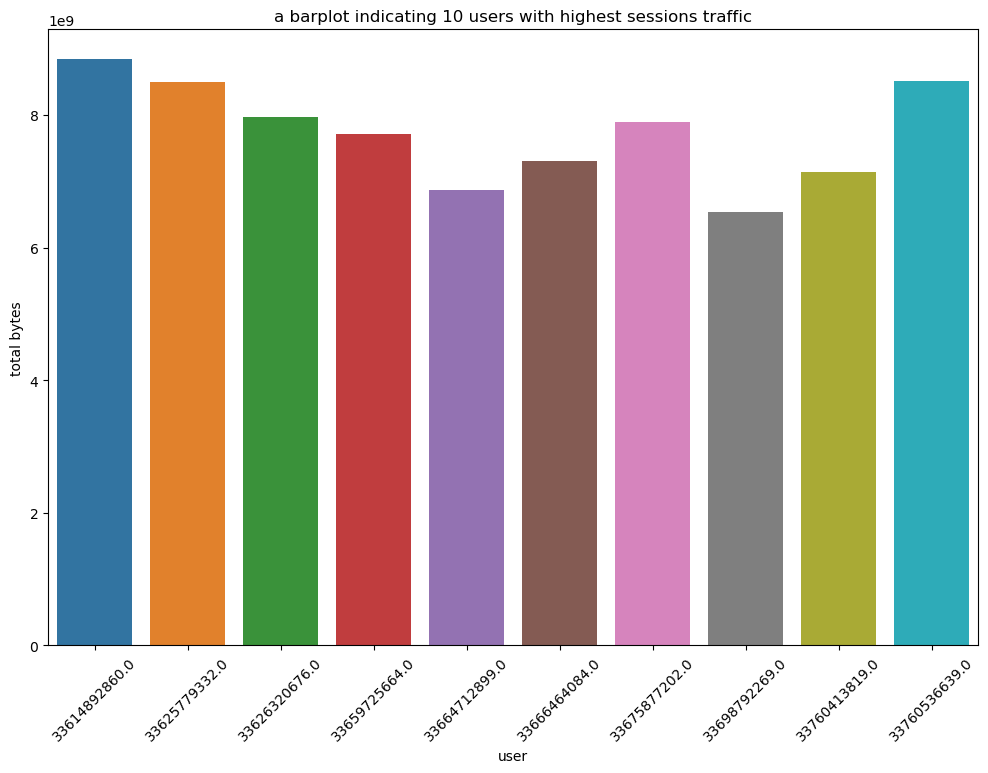

In [68]:
b = agg_user_data.sort_values(by = 'sessions_traffic(bytes)', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = b.index, y = b['sessions_traffic(bytes)'])
plt.ylabel('total bytes')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest sessions traffic')

# Top 10 users with longest sessions duration

Text(0.5, 1.0, 'a barplot indicating 10 users with longest sessions duration')

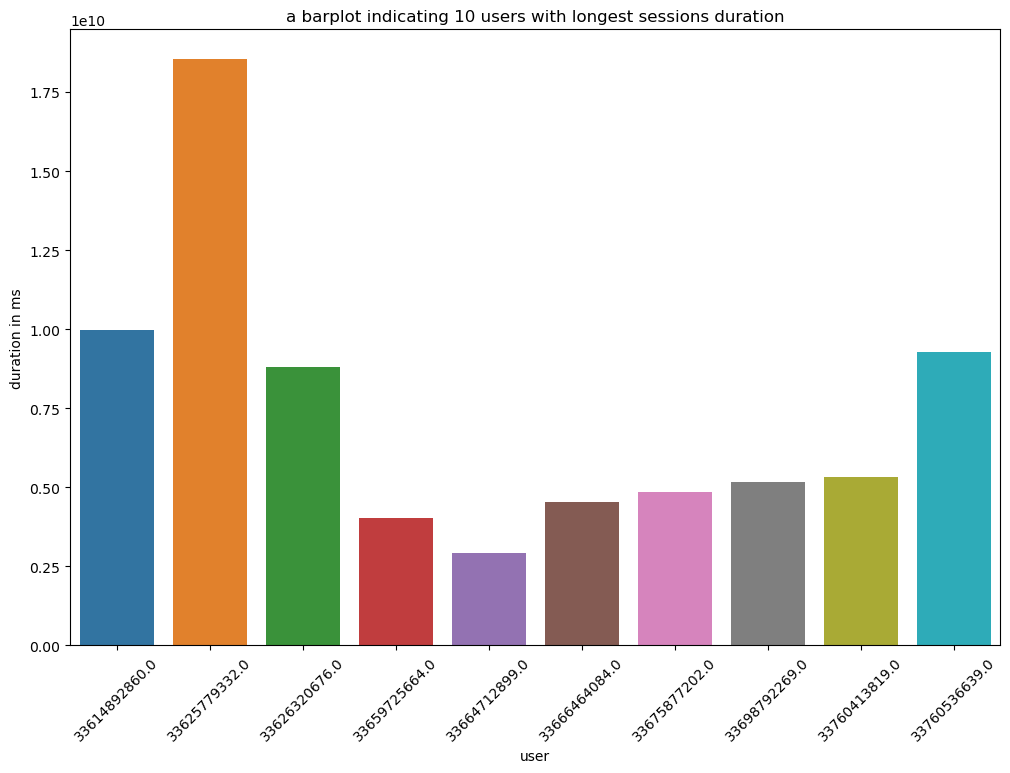

In [69]:
c = agg_user_data.sort_values(by = 'sessions_duration(ms)', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = b.index, y = b['sessions_duration(ms)'])
plt.ylabel('duration in ms')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with longest sessions duration')

In [70]:
a = a.index.to_list()
b = b.index.to_list()
c = c.index.to_list()

def IntersecOfSets(arr1, arr2, arr3): 
    s1 = set(arr1) 
    s2 = set(arr2) 
    s3 = set(arr3) 

    set1 = s1.intersection(s2)
    result_set = set1.intersection(s3) 
      
    final_list = list(result_set) 
    print(final_list) 
  
IntersecOfSets(a, b, c) 

[33625779332.0, 33626320676.0, 33760413819.0, 33614892860.0, 33760536639.0]


### Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement.

In [71]:
norm_agg_user_data = np.log1p(agg_user_data)
norm_agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes)
MSISDN/Number,,,
3.360100e+10,0.693147,18.575290,20.593943
3.360100e+10,0.693147,19.015283,18.870862
3.360100e+10,0.693147,18.720558,20.205695
3.360101e+10,0.693147,17.725091,19.861276
3.360101e+10,1.098612,17.429248,21.099927


In [72]:
norm_agg_user_data.shape

(106856, 3)

In [73]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
kmeans.fit(norm_agg_user_data)
kmeans_data = kmeans.predict(norm_agg_user_data)

In [74]:
norm_agg_user_data['clusters'] = pd.Series(kmeans_data, index=norm_agg_user_data.index)
norm_agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.360100e+10,0.693147,18.575290,20.593943,1
3.360100e+10,0.693147,19.015283,18.870862,1
3.360100e+10,0.693147,18.720558,20.205695,1
3.360101e+10,0.693147,17.725091,19.861276,2
3.360101e+10,1.098612,17.429248,21.099927,2


<Axes: >

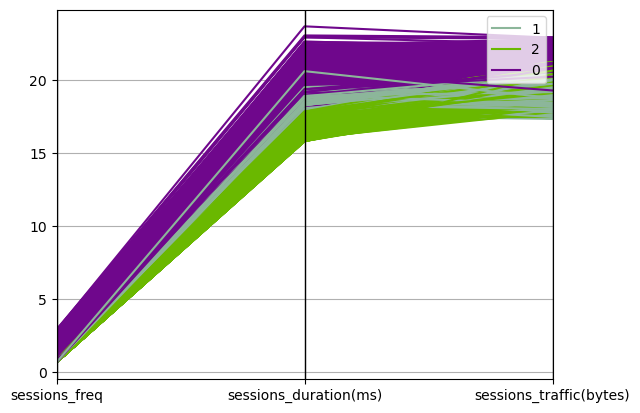

In [75]:
pd.plotting.parallel_coordinates(norm_agg_user_data, 'clusters')

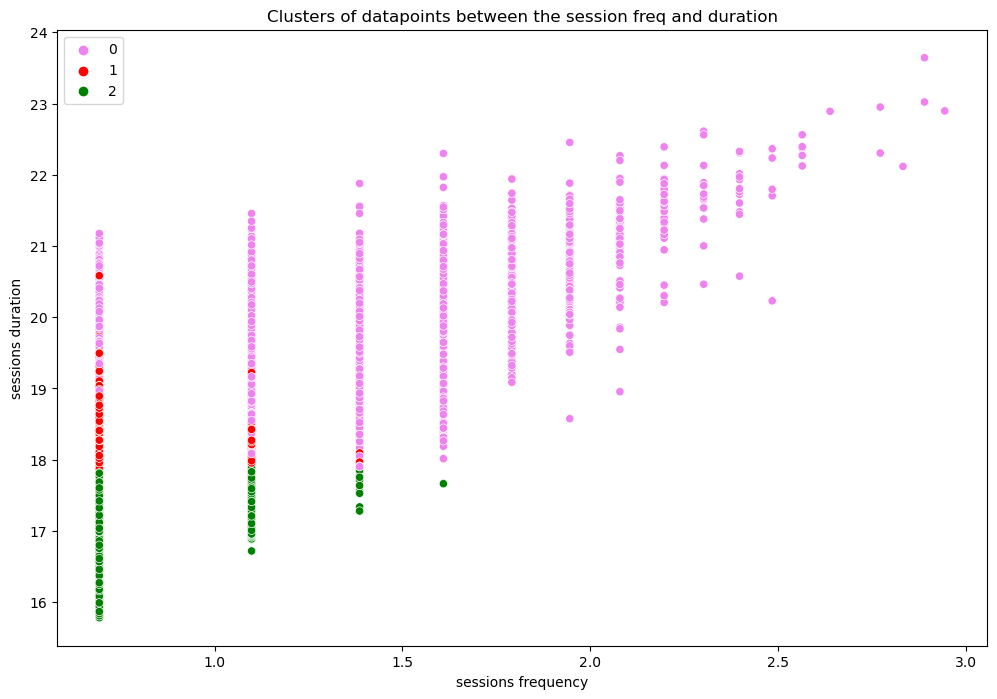

In [76]:
# comparing the clusters in variable pairs

x = norm_agg_user_data[['sessions_freq', 'sessions_duration(ms)', 'clusters']]
plt.figure(figsize = (12,8))
sns.scatterplot(x = norm_agg_user_data['sessions_freq'],  y = norm_agg_user_data['sessions_duration(ms)'], palette = ['violet', 'red', 'green'], hue = norm_agg_user_data['clusters'])

plt.title('Clusters of datapoints between the session freq and duration')
plt.xlabel('sessions frequency')
plt.ylabel('sessions duration')
plt.legend()

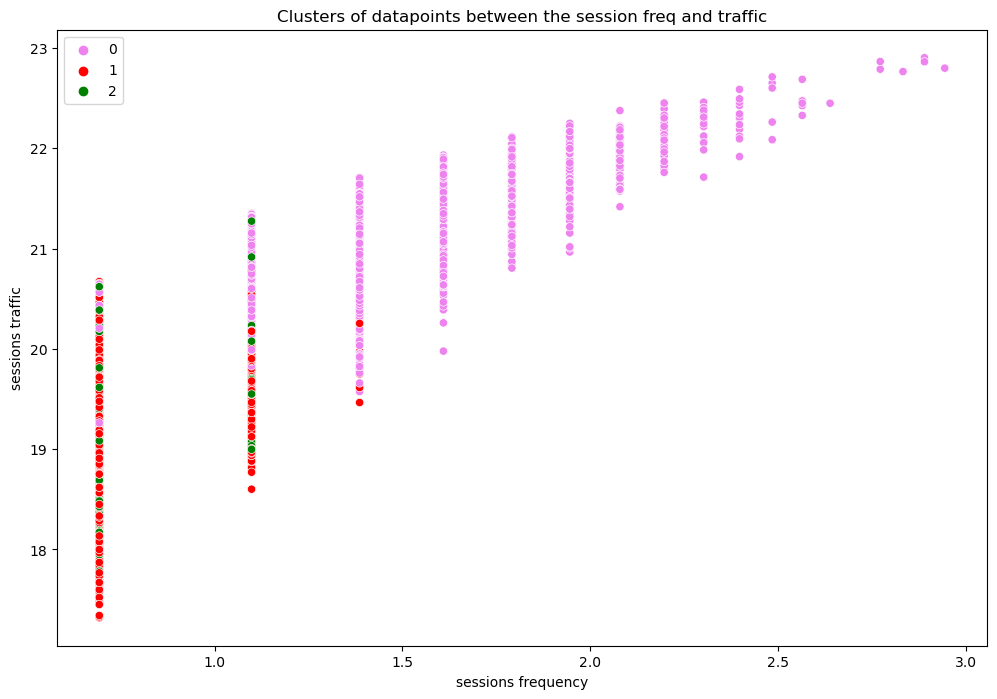

In [77]:
# frequency and traffic
x = norm_agg_user_data[['sessions_freq', 'sessions_traffic(bytes)', 'clusters']]
plt.figure(figsize = (12,8))
sns.scatterplot(x = norm_agg_user_data['sessions_freq'],  y = norm_agg_user_data['sessions_traffic(bytes)'], palette = ['violet', 'red', 'green'], hue = norm_agg_user_data['clusters'])

plt.title('Clusters of datapoints between the session freq and traffic')
plt.xlabel('sessions frequency')
plt.ylabel('sessions traffic')
plt.legend()

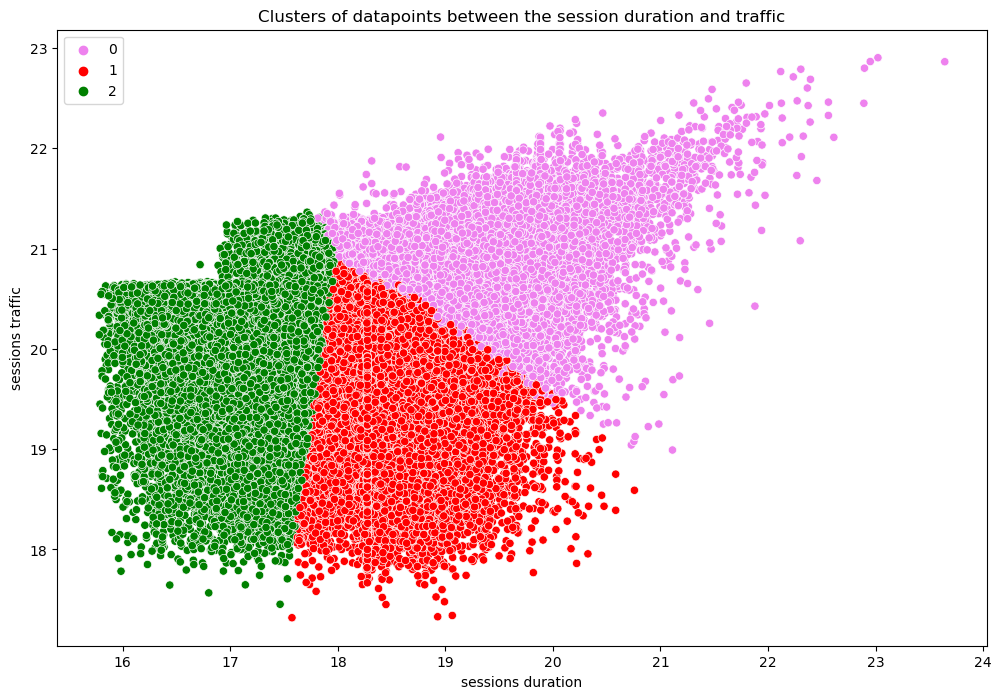

In [78]:
# duration and traffic
x = norm_agg_user_data[['sessions_duration(ms)', 'sessions_traffic(bytes)', 'clusters']]
plt.figure(figsize = (12,8))
sns.scatterplot(x = norm_agg_user_data['sessions_duration(ms)'],  y = norm_agg_user_data['sessions_traffic(bytes)'], palette = ['violet', 'red', 'green'], hue = norm_agg_user_data['clusters'])

plt.title('Clusters of datapoints between the session duration and traffic')
plt.xlabel('sessions duration')
plt.ylabel('sessions traffic')
plt.legend()

### Computing the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text

In [79]:
agg_user_data['clusters'] = kmeans_data
agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.360100e+10,1,116720140.0,8.786906e+08,1
3.360100e+10,1,181230963.0,1.568596e+08,1
3.360100e+10,1,134969374.0,5.959665e+08,1
3.360101e+10,1,49878024.0,4.223207e+08,2
3.360101e+10,2,37104453.0,1.457411e+09,2


In [80]:
agg_user_data.clusters.value_counts()

clusters
1    54884
0    29404
2    22568
Name: count, dtype: int64

In [81]:
cluster_1 = agg_user_data.loc[agg_user_data['clusters'] == 0]   
print(cluster_1.shape)
cluster_1.tail()

(29404, 4)


,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.378989e+10,1,173035258.0,8.529393e+08,0
3.378995e+10,2,209051329.0,1.540055e+09,0
3.378998e+10,2,210390146.0,1.094693e+09,0
3.197021e+12,1,877385325.0,2.321240e+08,0
3.370000e+14,1,253030201.0,5.962878e+08,0


In [82]:
cluster_1.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,29404.000000,2.940400e+04,2.940400e+04,29404.0
mean,2.223167,2.866913e+08,1.206964e+09,0.0
std,1.103703,2.997774e+08,5.764342e+08,0.0
min,1.000000,5.447539e+07,1.770069e+08,0.0
25%,2.000000,1.727957e+08,8.221958e+08,0.0
50%,2.000000,2.261406e+08,1.061664e+09,0.0
75%,3.000000,3.322111e+08,1.446074e+09,0.0
max,18.000000,1.855376e+10,8.846226e+09,0.0


In [83]:
cluster_2 = agg_user_data.loc[agg_user_data['clusters'] == 1]   
            
print(cluster_2.shape)
cluster_2.tail()

(54884, 4)


,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.378996e+10,1,98826284.0,645777687.0,1
3.378996e+10,1,157069852.0,710287575.0,1
3.378997e+10,1,160461578.0,208123067.0,1
3.379000e+10,1,140988659.0,480307335.0,1
8.823971e+14,1,869844200.0,139153646.0,1


In [84]:
cluster_2.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,54884.000000,5.488400e+04,5.488400e+04,54884.0
mean,1.065866,1.179514e+08,4.658057e+08,1.0
std,0.249369,5.133018e+07,2.359382e+08,0.0
min,1.000000,4.285693e+07,3.324901e+07,1.0
25%,1.000000,8.639992e+07,2.667423e+08,1.0
50%,1.000000,9.837724e+07,4.549593e+08,1.0
75%,1.000000,1.415167e+08,6.529198e+08,1.0
max,3.000000,1.035262e+09,1.214536e+09,1.0


In [85]:
cluster_3 = agg_user_data.loc[agg_user_data['clusters'] == 2]   
          
print(cluster_3.shape)
cluster_3.tail()

(22568, 4)


,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.378988e+10,1,47989629.0,610571467.0,2
3.378991e+10,1,44199417.0,902088414.0,2
3.378992e+10,1,54339643.0,576824365.0,2
3.378994e+10,1,36812757.0,193917233.0,2
3.379000e+10,1,8810688.0,714641641.0,2


In [86]:
cluster_3.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,22568.000000,2.256800e+04,2.256800e+04,22568.0
mean,1.110688,3.169990e+07,5.662260e+08,2.0
std,0.316004,1.339478e+07,2.961274e+08,0.0
min,1.000000,7.142988e+06,3.802236e+07,2.0
25%,1.000000,2.087691e+07,3.316123e+08,2.0
50%,1.000000,3.039026e+07,5.599833e+08,2.0
75%,1.000000,4.158170e+07,7.682524e+08,2.0
max,4.000000,6.510898e+07,1.895711e+09,2.0


### Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [87]:
apps_traffic = data[['social_media', 'netflix', 'youtube', 'google', 'email', 'gaming', 'other', 'MSISDN/Number']]
apps_traffic.tail()

,social_media,netflix,youtube,google,email,gaming,other,MSISDN/Number
149996,3.517065e+06,37561864.00,27955095.00,1.278491e+07,6.908760e+05,5.358069e+08,1.675193e+07,3.365069e+10
149997,2.352181e+06,40643294.00,22165518.00,4.415361e+06,2.121718e+06,6.316281e+08,7.146381e+08,3.366345e+10
149998,1.260239e+06,15029702.00,24516413.00,6.585469e+06,2.058277e+06,5.669338e+08,1.324156e+08,3.362189e+10
149999,8.231090e+05,16494842.00,17122508.00,7.757267e+06,2.850914e+06,3.550664e+08,8.161200e+08,3.361962e+10
150000,1.828250e+06,22628606.54,22643482.63,7.807295e+06,2.259102e+06,4.303331e+08,4.293653e+08,NaN


In [88]:
agg_apps_traffic = apps_traffic.groupby('MSISDN/Number').agg({'social_media':'sum', 'netflix':'sum', 'youtube':'sum', 'gaming':'sum', 
                                                            'google':'sum', 'email':'sum', 'other':'sum'})
agg_apps_traffic.head()

,social_media,netflix,youtube,gaming,google,email,other
MSISDN/Number,,,,,,,
3.360100e+10,2232135.0,27180981.0,21624548.0,8.124587e+08,4389005.0,1331362.0,386570872.0
3.360100e+10,2660565.0,11221763.0,12432223.0,1.197501e+08,5334863.0,3307781.0,281710071.0
3.360100e+10,3195623.0,19353900.0,21333570.0,5.388277e+08,3443126.0,3205380.0,501693672.0
3.360101e+10,280294.0,1942092.0,6977321.0,3.911261e+08,9678493.0,2284670.0,35279702.0
3.360101e+10,2912542.0,49201724.0,41533002.0,1.314798e+09,18499616.0,3305469.0,804804484.0


### 10 users with highest social media traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest social_media traffic')

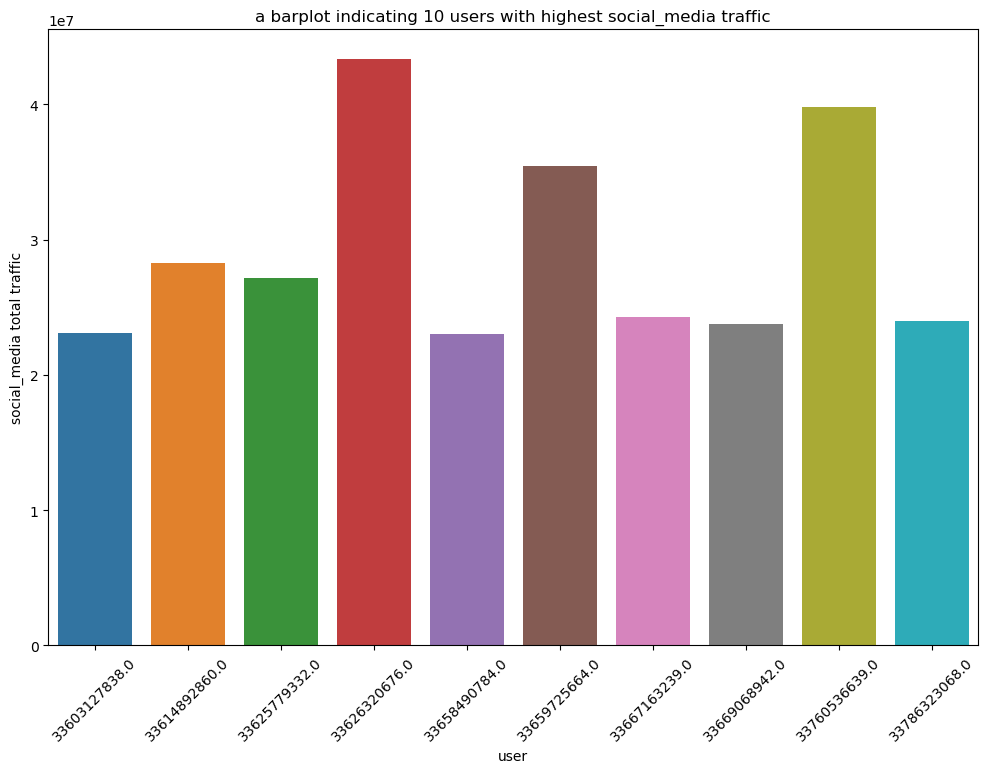

In [89]:
b = agg_apps_traffic.sort_values(by = 'social_media', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = b.index, y = b['social_media'])
plt.ylabel('social_media total traffic')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest social_media traffic')

### 10 users with highest gaming traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest gaming traffic')

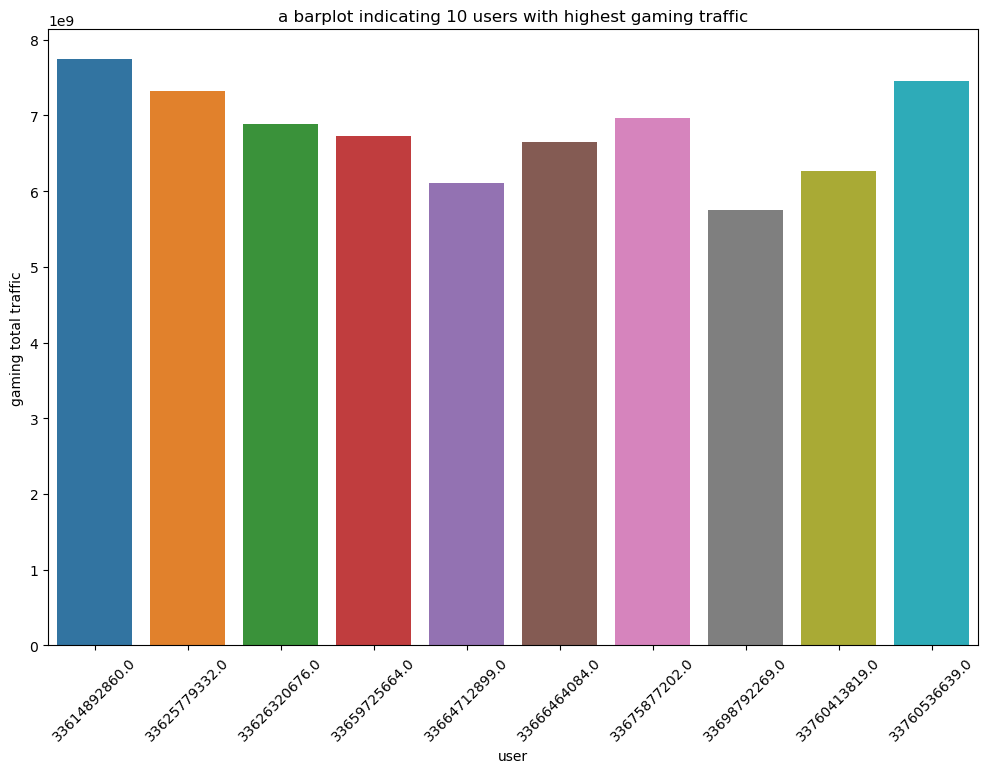

In [90]:
d = agg_apps_traffic.sort_values(by = 'gaming', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = d.index, y = d['gaming'])
plt.ylabel('gaming total traffic')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest gaming traffic')

### Plotting the top 3 most used applications

Most used applications can be determined by the Application with highest traffic data or the application with the most users.

In [91]:
agg_apps_traffic.loc['total_app_traffic'] = agg_apps_traffic.sum()  
agg_apps_traffic.tail()

,social_media,netflix,youtube,gaming,google,email,other
MSISDN/Number,,,,,,,
33789997247.0,4.985690e+05,8.531060e+06,1.985157e+07,4.370033e+08,5.429705e+06,2.514097e+06,2.111151e+08
3197020876596.0,7.152240e+05,2.659230e+07,1.195990e+07,1.780487e+08,1.043866e+07,1.520771e+06,4.705265e+08
337000037000919.0,5.215660e+05,3.090504e+07,3.673494e+07,5.101427e+08,9.830617e+06,3.318582e+06,1.491884e+08
882397108489451.0,1.546088e+06,2.884623e+07,4.094071e+07,4.307026e+07,9.218647e+06,3.330974e+06,4.013605e+08
total_app_traffic,2.722655e+11,3.370060e+12,3.372204e+12,6.408892e+13,1.162853e+12,3.364677e+11,6.395425e+13


Text(0.5, 0, 'application')

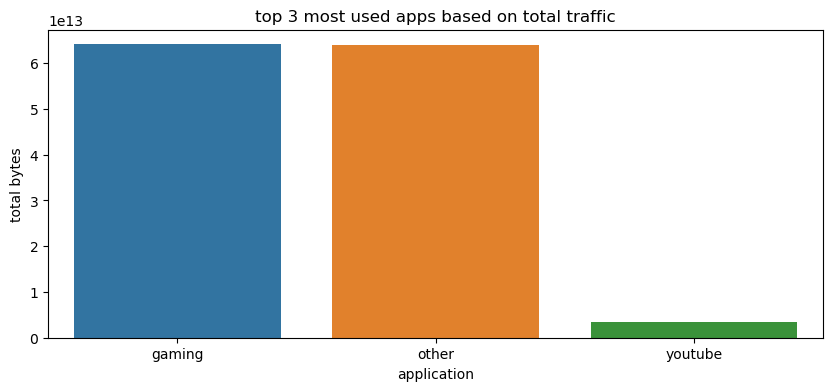

In [92]:
a = agg_apps_traffic.tail(1)
long_df = pd.melt(a)
long_df = long_df.sort_values(by = 'value', ascending = False).head(3)
plt.figure(figsize=(10,4))
sns.barplot(x = long_df.variable, y = long_df.value)
plt.title('top 3 most used apps based on total traffic')
plt.ylabel('total bytes')
plt.xlabel('application')

### Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics:

In [93]:
norm_agg_user_data = norm_agg_user_data.drop(['clusters'], axis = 1)
norm_agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes)
MSISDN/Number,,,
3.360100e+10,0.693147,18.575290,20.593943
3.360100e+10,0.693147,19.015283,18.870862
3.360100e+10,0.693147,18.720558,20.205695
3.360101e+10,0.693147,17.725091,19.861276
3.360101e+10,1.098612,17.429248,21.099927


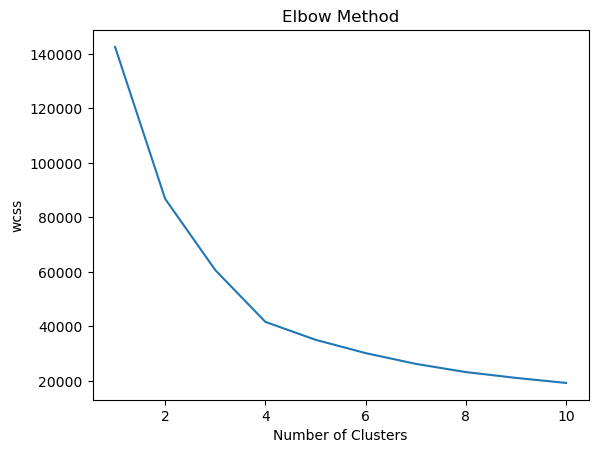

In [94]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(norm_agg_user_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

### K = 4

In [95]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=0)
kmeans.fit(norm_agg_user_data)
y_means = kmeans.predict(norm_agg_user_data)
agg_user_data['clusters'] = y_means

agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.360100e+10,1,116720140.0,8.786906e+08,0
3.360100e+10,1,181230963.0,1.568596e+08,3
3.360100e+10,1,134969374.0,5.959665e+08,0
3.360101e+10,1,49878024.0,4.223207e+08,2
3.360101e+10,2,37104453.0,1.457411e+09,2


In [96]:
cluster_1 = agg_user_data[agg_user_data.clusters == 0]
cluster_2 = agg_user_data[agg_user_data.clusters == 1]
cluster_3 = agg_user_data[agg_user_data.clusters == 2]
cluster_4 = agg_user_data[agg_user_data.clusters == 3]

In [97]:
cluster_1.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,46094.000000,4.609400e+04,4.609400e+04,46094.0
mean,1.191825,1.171705e+08,6.863861e+08,0.0
std,0.402083,4.461552e+07,2.314716e+08,0.0
min,1.000000,4.160388e+07,3.464750e+08,0.0
25%,1.000000,8.639991e+07,5.114233e+08,0.0
50%,1.000000,1.018567e+08,6.635212e+08,0.0
75%,1.000000,1.476831e+08,8.149324e+08,0.0
max,4.000000,3.518824e+08,2.287800e+09,0.0


In [98]:
cluster_2.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,20412.000000,2.041200e+04,2.041200e+04,20412.0
mean,2.533412,3.460266e+08,1.334685e+09,1.0
std,1.147925,3.421738e+08,6.298142e+08,0.0
min,1.000000,8.307244e+07,1.770069e+08,1.0
25%,2.000000,2.088515e+08,9.082630e+08,1.0
50%,2.000000,2.718630e+08,1.209339e+09,1.0
75%,3.000000,3.719152e+08,1.596745e+09,1.0
max,18.000000,1.855376e+10,8.846226e+09,1.0


In [99]:
cluster_3.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,19338.000000,1.933800e+04,1.933800e+04,19338.0
mean,1.070742,2.865160e+07,5.455455e+08,2.0
std,0.257406,1.140413e+07,2.613023e+08,0.0
min,1.000000,7.142988e+06,4.604748e+07,2.0
25%,1.000000,1.922928e+07,3.411720e+08,2.0
50%,1.000000,2.799957e+07,5.344812e+08,2.0
75%,1.000000,3.677040e+07,7.378057e+08,2.0
max,3.000000,5.910590e+07,1.789204e+09,2.0


In [100]:
cluster_4.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,21012.000000,2.101200e+04,2.101200e+04,21012.0
mean,1.027080,1.237817e+08,2.094904e+08,3.0
std,0.162905,6.735443e+07,8.197738e+07,0.0
min,1.000000,1.886284e+07,3.324901e+07,3.0
25%,1.000000,8.639989e+07,1.380606e+08,3.0
50%,1.000000,1.010637e+08,2.092688e+08,3.0
75%,1.000000,1.535040e+08,2.813051e+08,3.0
max,3.000000,1.042254e+09,3.538151e+08,3.0


# Task - 3. Experience Analytics

Aggregate, per customer, the following information (treat missing & outliers by replacing by the mean or the mode of the corresponding variable) -(jupyter notebook): Average TCP retransmission Average RTT Handset type Average throughput

In [101]:
net_data = data[['MSISDN/Number', 'Handset Type', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
                'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']]

net_data.head()

,MSISDN/Number,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
0,3.366496e+10,Samsung Galaxy A5 Sm-A520F,42.000000,5.000000,23.0,44.0,2.080991e+07,759658.664811
1,3.368185e+10,Samsung Galaxy J5 (Sm-J530),65.000000,5.000000,16.0,26.0,2.080991e+07,759658.664811
2,3.376063e+10,Samsung Galaxy A8 (2018),109.795706,17.662883,6.0,9.0,2.080991e+07,759658.664811
3,3.375034e+10,undefined,109.795706,17.662883,44.0,44.0,2.080991e+07,759658.664811
4,3.369980e+10,Samsung Sm-G390F,109.795706,17.662883,6.0,9.0,2.080991e+07,759658.664811


In [102]:
Q1 = np.percentile(net_data['Avg RTT DL (ms)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg RTT DL (ms)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg RTT DL (ms)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg RTT DL (ms)'], interpolation = 'midpoint') 
o = (net_data['Avg RTT DL (ms)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg RTT DL (ms)'] > (Q3 + 1.5 * IQR))
m = o.unique()

#RTT UL
Q1 = np.percentile(net_data['Avg RTT UL (ms)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg RTT UL (ms)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg RTT UL (ms)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg RTT UL (ms)'], interpolation = 'midpoint') 
o = (net_data['Avg RTT UL (ms)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg RTT UL (ms)'] > (Q3 + 1.5 * IQR))
n = o.unique()

#TP DL
Q1 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg Bearer TP DL (kbps)'], interpolation = 'midpoint') 
o = (net_data['Avg Bearer TP DL (kbps)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg Bearer TP DL (kbps)'] > (Q3 + 1.5 * IQR))
q = o.unique()

#TP UL
Q1 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg Bearer TP UL (kbps)'], interpolation = 'midpoint') 
o = (net_data['Avg Bearer TP UL (kbps)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg Bearer TP UL (kbps)'] > (Q3 + 1.5 * IQR))
p = o.unique()

#TCP UL
Q1 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['TCP UL Retrans. Vol (Bytes)'], interpolation = 'midpoint') 
o = (net_data['TCP UL Retrans. Vol (Bytes)'] < (Q1 - 1.5 * IQR)) |(net_data['TCP UL Retrans. Vol (Bytes)'] > (Q3 + 1.5 * IQR))
q = o.unique()

#TCP DL
Q1 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['TCP DL Retrans. Vol (Bytes)'], interpolation = 'midpoint') 
o = (net_data['TCP DL Retrans. Vol (Bytes)'] < (Q1 - 1.5 * IQR)) |(net_data['TCP DL Retrans. Vol (Bytes)'] > (Q3 + 1.5 * IQR))
r = o.unique()

print('rtt dl', m)
print('rtt ul', n)
print('tp ul', p)
print('tp dl', q)
print('tcp dl', r)
print('tcp ul', q)

rtt dl [False  True]
rtt ul [False  True]
tp ul [False  True]
tp dl [False  True]
tcp dl [False  True]
tcp ul [False  True]


They all have outliers, now we have to treat them by replacing them with the low and high percentiles.

In [103]:
net_data['Avg RTT DL (ms)'] = net_data['Avg RTT DL (ms)'].clip(lower=net_data['Avg RTT DL (ms)'].quantile(0.07), upper=net_data['Avg RTT DL (ms)'].quantile(0.93))
net_data['Avg RTT UL (ms)'] = net_data['Avg RTT UL (ms)'].clip(lower=net_data['Avg RTT UL (ms)'].quantile(0.10), upper=net_data['Avg RTT UL (ms)'].quantile(0.90))
net_data['Avg Bearer TP DL (kbps)'] = net_data['Avg Bearer TP DL (kbps)'].clip(lower=net_data['Avg Bearer TP DL (kbps)'].quantile(0.05), upper=net_data['Avg Bearer TP DL (kbps)'].quantile(0.95))
net_data['Avg Bearer TP UL (kbps)'] = net_data['Avg Bearer TP UL (kbps)'].clip(lower=net_data['Avg Bearer TP UL (kbps)'].quantile(0.20), upper=net_data['Avg Bearer TP UL (kbps)'].quantile(0.80))
net_data['TCP UL Retrans. Vol (Bytes)'] = net_data['TCP UL Retrans. Vol (Bytes)'].clip(lower=net_data['TCP UL Retrans. Vol (Bytes)'].quantile(0.05), upper=net_data['TCP UL Retrans. Vol (Bytes)'].quantile(0.95))
net_data['TCP DL Retrans. Vol (Bytes)'] = net_data['TCP DL Retrans. Vol (Bytes)'].clip(lower=net_data['TCP DL Retrans. Vol (Bytes)'].quantile(0.05), upper=net_data['TCP DL Retrans. Vol (Bytes)'].quantile(0.95))

In [104]:
Q1 = np.percentile(net_data['Avg RTT DL (ms)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg RTT DL (ms)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg RTT DL (ms)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg RTT DL (ms)'], interpolation = 'midpoint') 
o = (net_data['Avg RTT DL (ms)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg RTT DL (ms)'] > (Q3 + 1.5 * IQR))
m = o.unique()

#RTT UL
Q1 = np.percentile(net_data['Avg RTT UL (ms)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg RTT UL (ms)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg RTT UL (ms)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg RTT UL (ms)'], interpolation = 'midpoint') 
o = (net_data['Avg RTT UL (ms)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg RTT UL (ms)'] > (Q3 + 1.5 * IQR))
n = o.unique()

#TP DL
Q1 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg Bearer TP DL (kbps)'], interpolation = 'midpoint') 
o = (net_data['Avg Bearer TP DL (kbps)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg Bearer TP DL (kbps)'] > (Q3 + 1.5 * IQR))
q = o.unique()

#TP UL
Q1 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg Bearer TP UL (kbps)'], interpolation = 'midpoint') 
o = (net_data['Avg Bearer TP UL (kbps)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg Bearer TP UL (kbps)'] > (Q3 + 1.5 * IQR))
p = np.unique(o, return_counts = True)

#TCP UL
Q1 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['TCP UL Retrans. Vol (Bytes)'], interpolation = 'midpoint') 
o = (net_data['TCP UL Retrans. Vol (Bytes)'] < (Q1 - 1.5 * IQR)) |(net_data['TCP UL Retrans. Vol (Bytes)'] > (Q3 + 1.5 * IQR))
q = o.unique()

#TCP DL
Q1 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['TCP DL Retrans. Vol (Bytes)'], interpolation = 'midpoint') 
o = (net_data['TCP DL Retrans. Vol (Bytes)'] < (Q1 - 1.5 * IQR)) |(net_data['TCP DL Retrans. Vol (Bytes)'] > (Q3 + 1.5 * IQR))
r = o.unique()

print('rtt dl', m)
print('rtt ul', n)
print('tp ul', p)
print('tp dl', q)
print('tcp dl', r)
print('tcp ul', q)

rtt dl [False]
rtt ul [False]
tp ul (array([False]), array([150001], dtype=int64))
tp dl [False]
tcp dl [False]
tcp ul [False]


Looking good now

In [105]:
net_data['total_tp(kbps)'] = data['Avg Bearer TP DL (kbps)'] + data['Avg Bearer TP UL (kbps)']
net_data['total_rtt(ms)'] = data['Avg RTT DL (ms)'] + data['Avg RTT UL (ms)']
net_data['total_tcp(bytes)'] = data['TCP DL Retrans. Vol (Bytes)'] + data['TCP UL Retrans. Vol (Bytes)']
net_data.head()

,MSISDN/Number,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),total_tp(kbps),total_rtt(ms),total_tcp(bytes)
0,3.366496e+10,Samsung Galaxy A5 Sm-A520F,42.000000,5.000000,23.0,45.0,2.080991e+07,759658.664811,67.0,47.000000,2.156957e+07
1,3.368185e+10,Samsung Galaxy J5 (Sm-J530),65.000000,5.000000,16.0,45.0,2.080991e+07,759658.664811,42.0,70.000000,2.156957e+07
2,3.376063e+10,Samsung Galaxy A8 (2018),109.795706,17.662883,11.0,45.0,2.080991e+07,759658.664811,15.0,127.458589,2.156957e+07
3,3.375034e+10,undefined,109.795706,17.662883,44.0,45.0,2.080991e+07,759658.664811,88.0,127.458589,2.156957e+07
4,3.369980e+10,Samsung Sm-G390F,109.795706,17.662883,11.0,45.0,2.080991e+07,759658.664811,15.0,127.458589,2.156957e+07


In [106]:
# handset type
a = net_data[['MSISDN/Number', 'Handset Type']]
b = a.groupby('MSISDN/Number').count()
print(b.shape)
b = b.reset_index()
b.head()

(106856, 1)


,MSISDN/Number,Handset Type
0,3.360100e+10,1
1,3.360100e+10,1
2,3.360100e+10,1
3,3.360101e+10,1
4,3.360101e+10,2


In [107]:
# the others
c = net_data.drop(['Handset Type'], axis = 1)
d = c.groupby('MSISDN/Number').sum()
d = d.reset_index()
print(d.shape)
d.head()

(106856, 10)


,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),total_tp(kbps),total_rtt(ms),total_tcp(bytes)
0,3.360100e+10,46.000000,1.000000,37.0,45.0,2.080991e+07,759658.664811,76.0,46.000000,2.156957e+07
1,3.360100e+10,30.000000,1.000000,48.0,51.0,2.080991e+07,759658.664811,99.0,31.000000,2.156957e+07
2,3.360100e+10,109.795706,17.662883,48.0,49.0,2.080991e+07,759658.664811,97.0,127.458589,2.156957e+07
3,3.360101e+10,69.000000,15.000000,204.0,45.0,4.316000e+03,759658.664811,248.0,84.000000,7.607247e+05
4,3.360101e+10,114.000000,6.000000,40395.0,1673.0,3.015954e+07,780860.664811,56844.0,119.000000,3.094040e+07


In [108]:
# Merging them
agg_net_data = pd.merge(left=b, right=d, how='left', left_on='MSISDN/Number', right_on='MSISDN/Number')
print(agg_net_data.shape)
agg_net_data.head()

(106856, 11)


,MSISDN/Number,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),total_tp(kbps),total_rtt(ms),total_tcp(bytes)
0,3.360100e+10,1,46.000000,1.000000,37.0,45.0,2.080991e+07,759658.664811,76.0,46.000000,2.156957e+07
1,3.360100e+10,1,30.000000,1.000000,48.0,51.0,2.080991e+07,759658.664811,99.0,31.000000,2.156957e+07
2,3.360100e+10,1,109.795706,17.662883,48.0,49.0,2.080991e+07,759658.664811,97.0,127.458589,2.156957e+07
3,3.360101e+10,1,69.000000,15.000000,204.0,45.0,4.316000e+03,759658.664811,248.0,84.000000,7.607247e+05
4,3.360101e+10,2,114.000000,6.000000,40395.0,1673.0,3.015954e+07,780860.664811,56844.0,119.000000,3.094040e+07


### Computing & listing  10 of the top, bottom and most frequent:

TCP values in the dataset.

RTT values in the dataset.

Throughput values in the dataset.

In [109]:
tcp = data.sort_values(by = 'total_tcp', ascending = False)
top_tcp = tcp.total_tcp.head(10)
bottom_tcp = tcp.total_tcp.tail(10)
fre_tcp = data.total_tcp.value_counts(ascending = False).head(10)
print('top tcp\n', top_tcp.to_list())
print('bottom tcp\n', bottom_tcp.to_list())
print('freq tcp\n', fre_tcp.index.to_list())

top tcp
 [4344115651.0, 4301477439.0, 4294431965.0, 4291464950.0, 4288120860.0, 4275491713.0, 4268647350.0, 4261616039.0, 4260174145.0, 4254659643.0]
bottom tcp
 [143.0, 134.0, 134.0, 129.0, 128.0, 113.0, 108.0, 106.0, 97.0, 86.0]
freq tcp
 [21569572.935152996, 20811208.27034193, 760988.6648110661, 20811244.27034193, 759696.6648110661, 759750.6648110661, 20811232.27034193, 762318.6648110661, 760976.6648110661, 20812574.27034193]


In [110]:
rtt = data.sort_values(by = 'total_rtt', ascending = False)
top_rtt= rtt.total_rtt.head(10)
bottom_rtt = rtt.total_rtt.tail(10)
fre_rtt = data.total_rtt.value_counts(ascending = False).head(10)
print('top rtt\n', top_rtt.to_list())
print('bottom rtt\n', bottom_rtt.to_list())
print('freq rtt\n', fre_rtt.index.to_list())

top rtt
 [96924.0, 64641.0, 55812.0, 54848.0, 27278.0, 26300.0, 25922.0, 25715.0, 25388.0, 24738.0]
bottom rtt
 [6.0, 6.0, 5.0, 4.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0]
freq rtt
 [127.45858896466059, 29.0, 39.0, 38.0, 40.0, 30.0, 28.0, 49.0, 41.0, 31.0]


In [111]:
tp = data.sort_values(by = 'total_tp', ascending = False)
top_tp = tp.total_tp.head(10)
bottom_tp = tp.total_tp.tail(10)
fre_tp = data.total_tp.value_counts(ascending = False).head(10)
print('top tp\n', top_tp.to_list())
print('bottom tp\n', bottom_tp.to_list())
print('freq tp\n', fre_tp.index.to_list())

top tp
 [382262.0, 313244.0, 304299.0, 300546.0, 283931.0, 281144.0, 277152.0, 276205.0, 274052.0, 269888.0]
bottom tp
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
freq tp
 [63.0, 15.0, 97.0, 90.0, 98.0, 96.0, 99.0, 89.0, 91.0, 93.0]


In [112]:
# tcp
a = agg_net_data.sort_values(by = 'total_tcp(bytes)', ascending = False).head(10)
b = agg_net_data.sort_values(by = 'total_tcp(bytes)', ascending = False).tail(10)
c = pd.DataFrame(agg_net_data['total_tcp(bytes)'].value_counts(ascending = False).head(10))

[Text(0.5, 1.0, 'Top 10 TCP values'), Text(0.5, 0, 'users')]

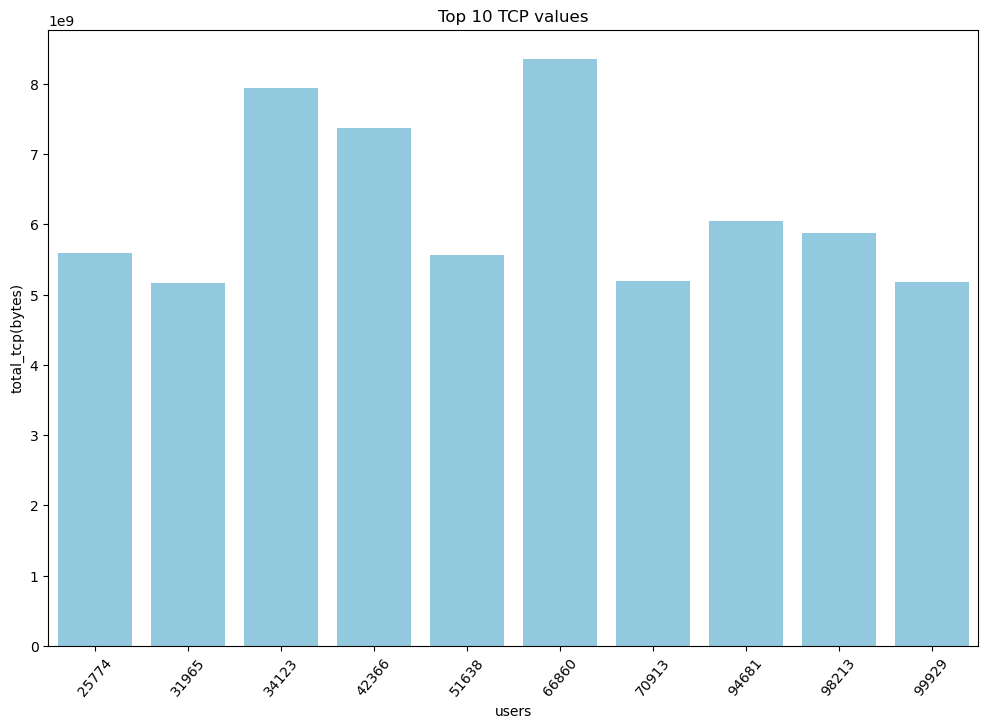

In [113]:
# top 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = a.index ,y = a['total_tcp(bytes)'], color="skyblue").set(title = 'Top 10 TCP values', xlabel = 'users')

[Text(0.5, 1.0, 'Bottom 10 TCP values'), Text(0.5, 0, 'users')]

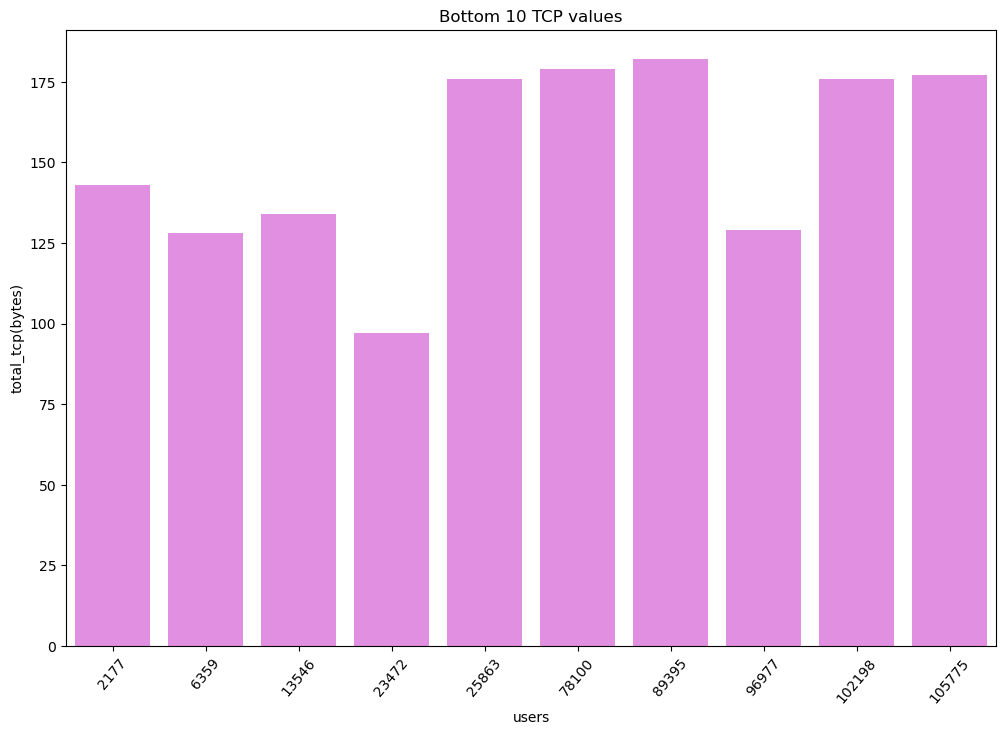

In [114]:
# bottom 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = b.index ,y = b['total_tcp(bytes)'], color="violet").set(title = 'Bottom 10 TCP values', xlabel = 'users')

In [115]:
# rtt
a = agg_net_data.sort_values(by = 'total_rtt(ms)', ascending = False).head(10)
b = agg_net_data.sort_values(by = 'total_rtt(ms)', ascending = False).tail(10)
c = pd.DataFrame(agg_net_data['total_rtt(ms)'].value_counts(ascending = False).head(10))

[Text(0.5, 1.0, 'Top 10 rtt values'), Text(0.5, 0, 'users')]

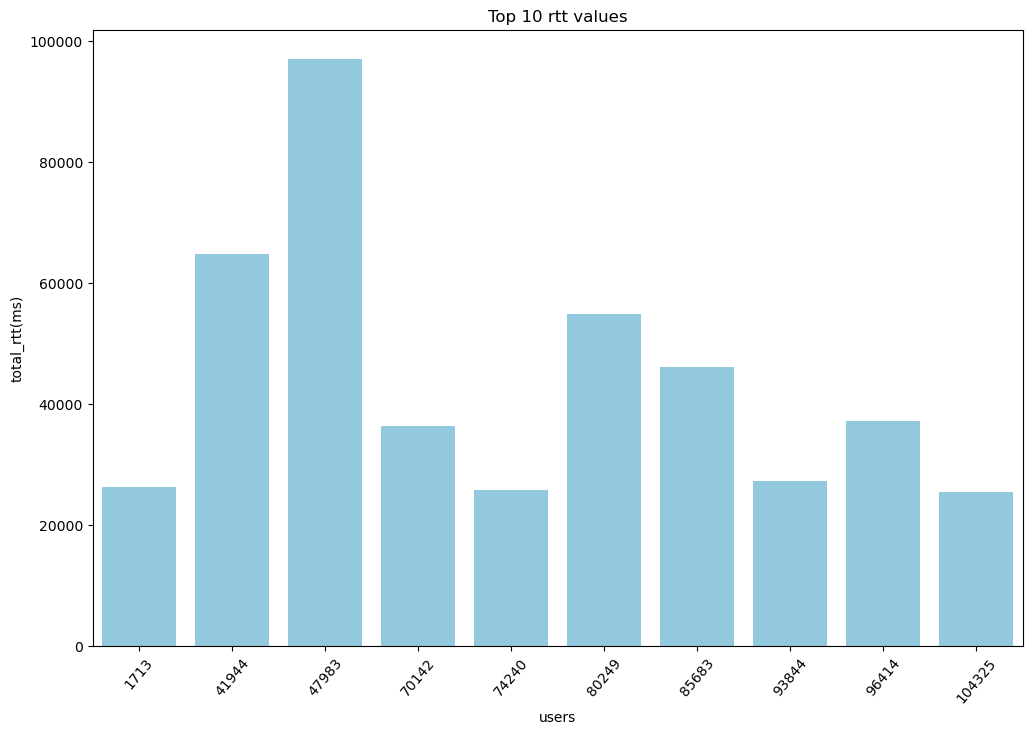

In [116]:
# top 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = a.index ,y = a['total_rtt(ms)'], color="skyblue").set(title = 'Top 10 rtt values', xlabel = 'users')

[Text(0.5, 1.0, 'Bottom 10 rtt values'), Text(0.5, 0, 'users')]

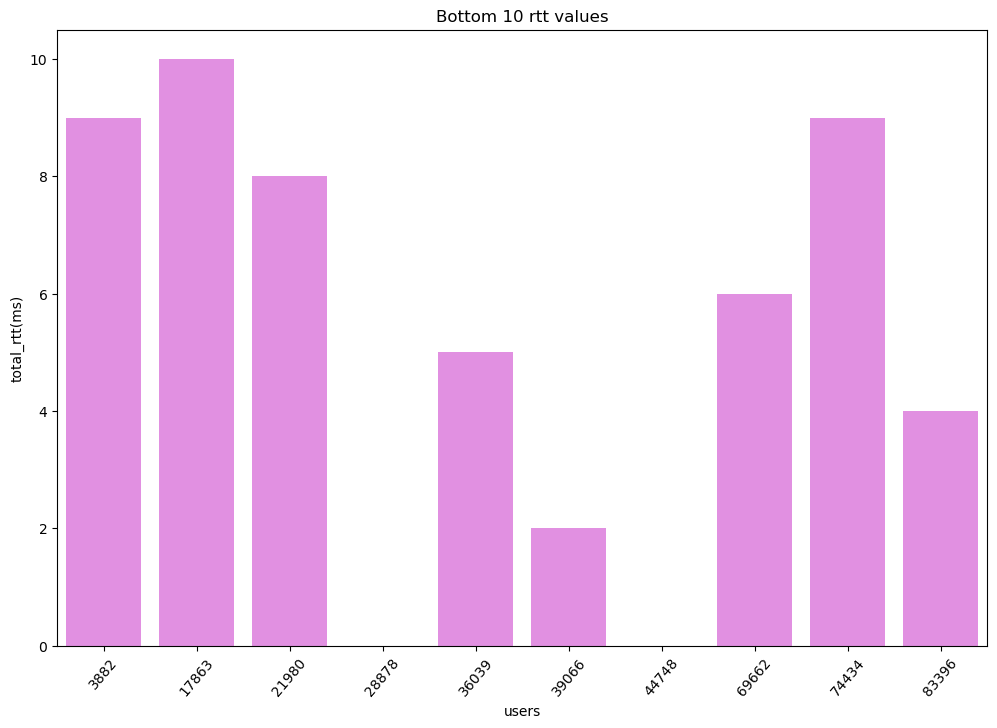

In [117]:
# bottom 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = b.index ,y = b['total_rtt(ms)'], color="violet").set(title = 'Bottom 10 rtt values', xlabel = 'users')

In [118]:
# tp
a = agg_net_data.sort_values(by = 'total_tp(kbps)', ascending = False).head(10)
b = agg_net_data.sort_values(by = 'total_tp(kbps)', ascending = False).tail(10)
c = pd.DataFrame(agg_net_data['total_tp(kbps)'].value_counts(ascending = False).head(10))

[Text(0.5, 1.0, 'Top 10 tp values'), Text(0.5, 0, 'users')]

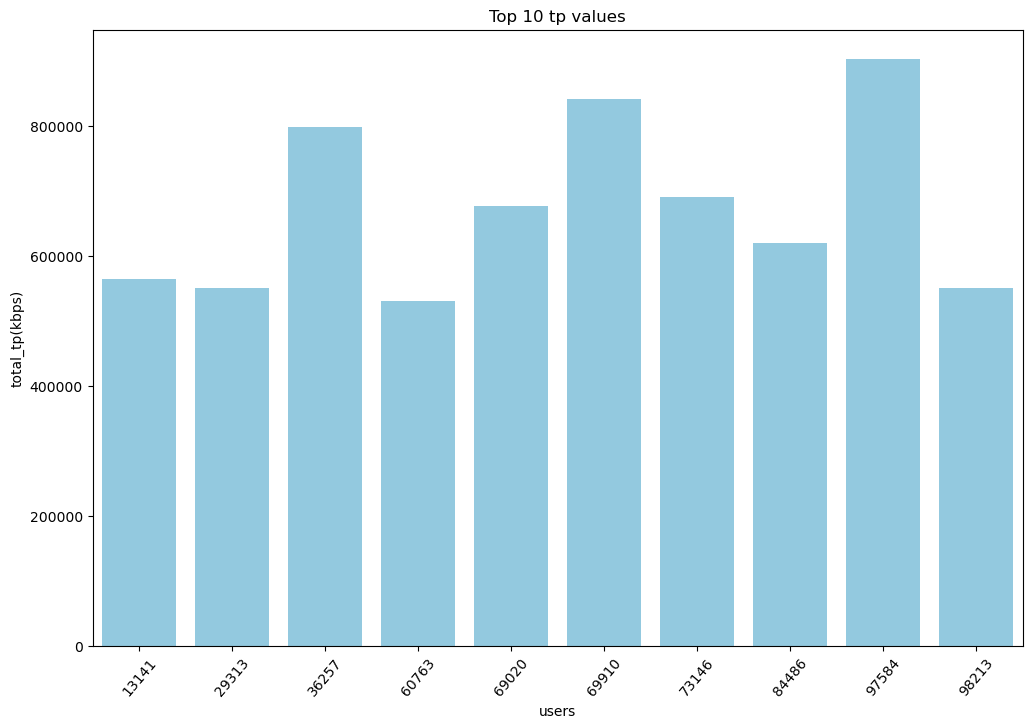

In [119]:
# top 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = a.index ,y = a['total_tp(kbps)'], color="skyblue").set(title = 'Top 10 tp values', xlabel = 'users')

[Text(0.5, 1.0, 'Bottom 10 tp values'), Text(0.5, 0, 'users')]

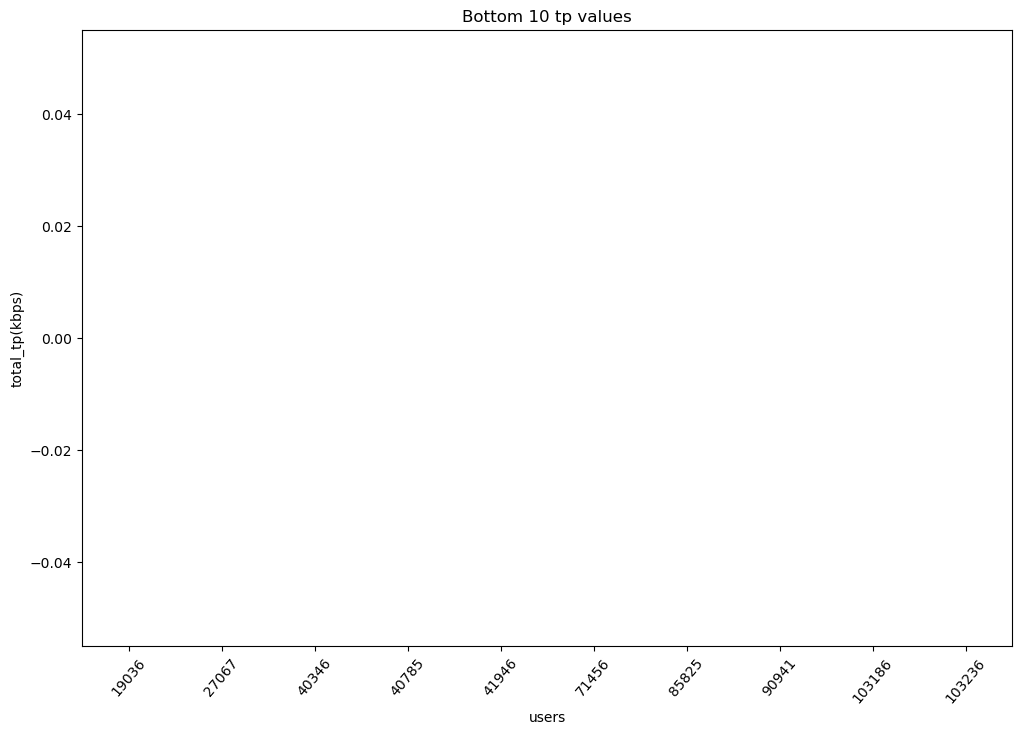

In [120]:
# bottom 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = b.index ,y = b['total_tp(kbps)'], color="violet").set(title = 'Bottom 10 tp values', xlabel = 'users')

all zeros

The distribution of the average throughput per handset type and provide interpretation for your findings.

The average TCP retransmission view per handset type and provide interpretation for your findings.

In [121]:
data['total_tp(kbps)'] = data['Avg Bearer TP DL (kbps)'] + data['Avg Bearer TP UL (kbps)']
data['total_rtt(ms)'] = data['Avg RTT DL (ms)'] + data['Avg RTT UL (ms)']
data['total_tcp(bytes)'] = data['TCP DL Retrans. Vol (Bytes)'] + data['TCP UL Retrans. Vol (Bytes)']

handset_data = data[['Handset Type', 'total_tp(kbps)', 'total_tcp(bytes)']]
agg_handset_data = handset_data.groupby('Handset Type').mean()
agg_handset_data.columns = ['avg_tp_per_set', 'avg_tcp_per_set']
agg_handset_data.head()

,avg_tp_per_set,avg_tcp_per_set
Handset Type,,
A-Link Telecom I. Cubot A5,23510.0,2.156957e+07
A-Link Telecom I. Cubot Note Plus,6699.0,6.162130e+05
A-Link Telecom I. Cubot Note S,8937.0,4.141173e+07
A-Link Telecom I. Cubot Nova,56217.0,1.371700e+05
A-Link Telecom I. Cubot Power,69468.0,8.041000e+03



 mu = 12400.38 and sigma = 14661.81



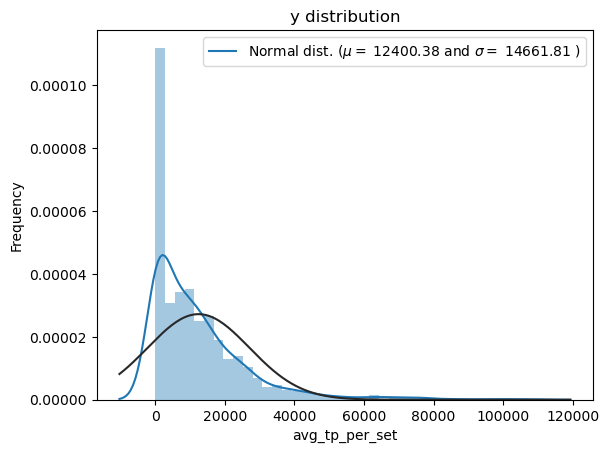

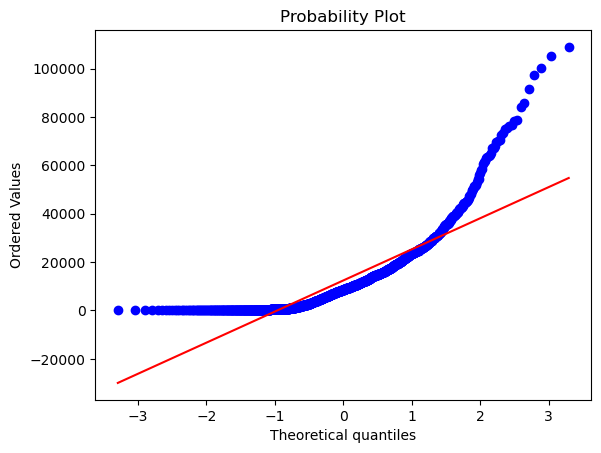

In [122]:
# Average throughput/handset ~ distribution

sns.distplot(agg_handset_data['avg_tp_per_set'] , fit=norm);

(mu, sigma) = norm.fit(agg_handset_data['avg_tp_per_set'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(agg_handset_data['avg_tp_per_set'], plot=plt)
plt.show()

Heavily right tailed - Highly skewed.

[Text(0.5, 1.0, 'Top 10 handsets types per average tcp value'),
 Text(0.5, 0, 'handset type')]

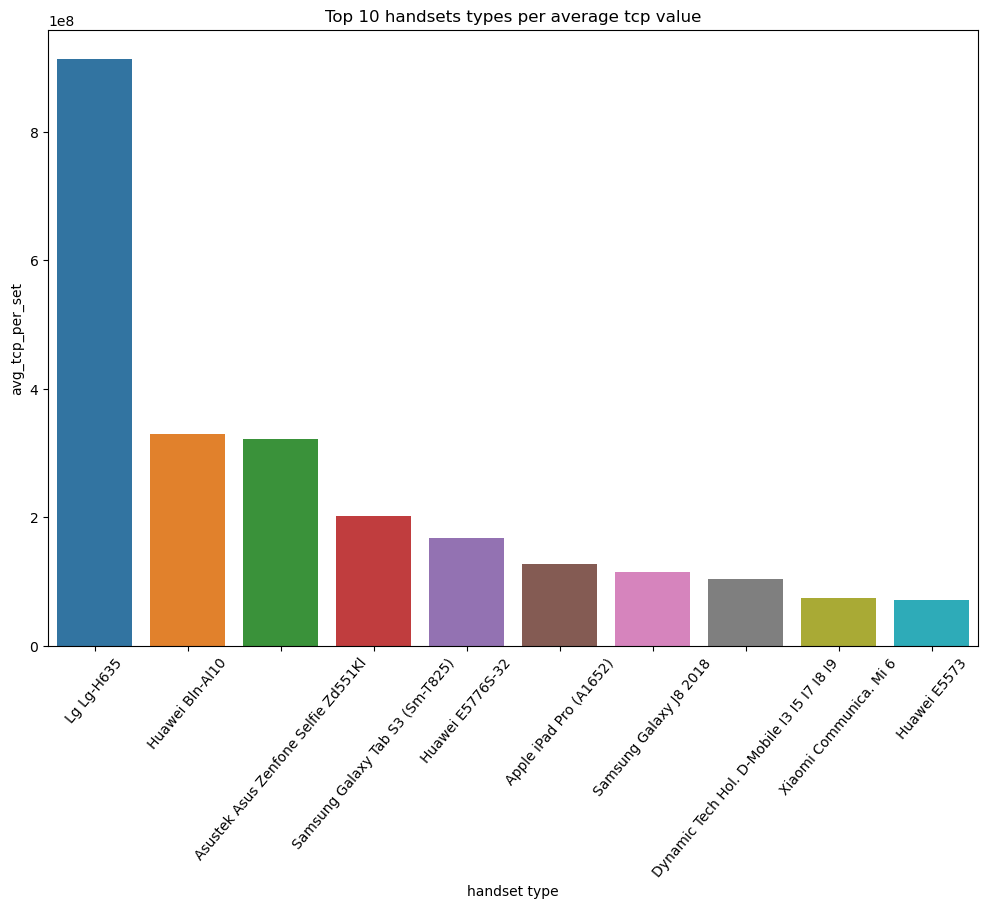

In [123]:
a = agg_handset_data.sort_values(by = 'avg_tcp_per_set', ascending = False).head(10)

plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = a.index ,y = a['avg_tcp_per_set']).set(title = 'Top 10 handsets types per average tcp value', xlabel = 'handset type')

6 of the handset types with highest average tcp values are from the top 3 handset manufacturers.

[Text(0.5, 1.0, 'Bottom 10 handsets types per average tcp value'),
 Text(0.5, 0, 'handset type')]

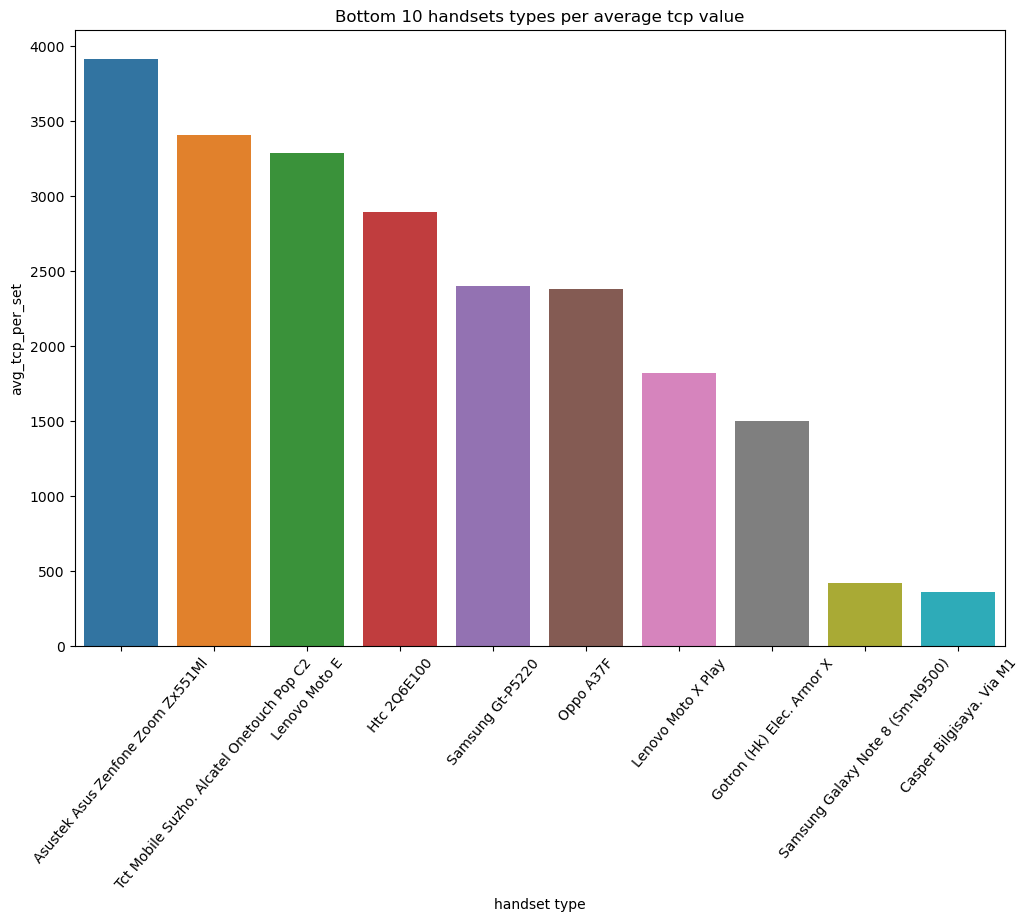

In [124]:
b = agg_handset_data.sort_values(by = 'avg_tcp_per_set', ascending = False).tail(10)

plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = b.index ,y = b['avg_tcp_per_set']).set(title = 'Bottom 10 handsets types per average tcp value', xlabel = 'handset type')

### Using the experience metrics above, perform a k-means clustering (where k = 3) to segment users into groups of experiences and provide a brief description of each cluster.

In [125]:
cluster_data = agg_net_data[['Handset Type', 'total_tp(kbps)', 'total_rtt(ms)',  'total_tcp(bytes)']]
norm_cluster_data = np.log1p(cluster_data)   
norm_cluster_data.head()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes)
0,0.693147,4.343805,3.850148,16.886794
1,0.693147,4.605170,3.465736,16.886794
2,0.693147,4.584967,4.855607,16.886794
3,0.693147,5.517453,4.442651,13.542028
4,1.098612,10.948084,4.787492,17.247574


In [126]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
kmeans.fit(norm_cluster_data)
kmeans_data = kmeans.predict(norm_cluster_data)

In [127]:
cluster_data['clusters'] = pd.Series(kmeans_data, index=cluster_data.index)
cluster_data['clusters'] = pd.Series(kmeans_data, index=cluster_data.index)
cluster_data.head()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),clusters
0,1,76.0,46.000000,2.156957e+07,1
1,1,99.0,31.000000,2.156957e+07,1
2,1,97.0,127.458589,2.156957e+07,1
3,1,248.0,84.000000,7.607247e+05,1
4,2,56844.0,119.000000,3.094040e+07,0


In [128]:
cluster_1 = cluster_data[cluster_data.clusters == 0]
cluster_2 = cluster_data[cluster_data.clusters == 1]
cluster_3 = cluster_data[cluster_data.clusters == 2]

In [129]:
cluster_1.describe()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),clusters
count,28950.000000,28950.000000,28950.000000,2.895000e+04,28950.0
mean,2.020622,59521.925389,254.669360,6.033107e+07,0.0
std,1.142551,61153.347742,512.323262,2.915427e+08,0.0
min,1.000000,1157.000000,17.000000,1.183841e+06,0.0
25%,1.000000,19697.250000,88.000000,1.077125e+07,0.0
50%,2.000000,42861.000000,149.000000,2.187849e+07,0.0
75%,2.000000,76656.250000,261.343942,3.488464e+07,0.0
max,18.000000,902222.000000,37084.000000,8.354209e+09,0.0


In [130]:
cluster_2.describe()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),clusters
count,57867.000000,57867.000000,57867.000000,5.786700e+04,57867.0
mean,1.199181,161.199008,121.934653,2.522595e+07,1.0
std,0.500237,238.588215,721.290566,1.163534e+07,0.0
min,1.000000,0.000000,0.000000,2.398920e+05,1.0
25%,1.000000,77.000000,38.000000,2.156957e+07,1.0
50%,1.000000,99.000000,69.000000,2.156957e+07,1.0
75%,1.000000,132.000000,127.458589,2.156957e+07,1.0
max,9.000000,2340.000000,96924.000000,5.395976e+08,1.0


In [131]:
cluster_3.describe()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),clusters
count,20039.000000,20039.000000,20039.000000,2.003900e+04,20039.0
mean,1.050202,25451.378811,217.611612,5.498388e+05,2.0
std,0.246494,27971.351438,702.685446,5.061885e+05,0.0
min,1.000000,38.000000,19.000000,9.700000e+01,2.0
25%,1.000000,4774.500000,49.000000,7.408950e+04,2.0
50%,1.000000,16964.000000,72.000000,4.901720e+05,2.0
75%,1.000000,36841.500000,154.000000,7.915787e+05,2.0
max,5.000000,382871.000000,27278.000000,3.340765e+06,2.0


# Task - 4.  Satisfaction Analysis

Consider the engagement score as the Euclidean distance between the user data point & the less engaged cluster (use the first clustering for this).

In [132]:
norm_agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes)
MSISDN/Number,,,
3.360100e+10,0.693147,18.575290,20.593943
3.360100e+10,0.693147,19.015283,18.870862
3.360100e+10,0.693147,18.720558,20.205695
3.360101e+10,0.693147,17.725091,19.861276
3.360101e+10,1.098612,17.429248,21.099927


In [133]:
norm_agg_user_data.shape

(106856, 3)

In [134]:
norm_agg_user_data.value_counts()

sessions_freq  sessions_duration(ms)  sessions_traffic(bytes)
0.693147       15.781642              20.140470                  1
               19.045277              20.581350                  1
               19.049013              20.319206                  1
               19.048976              20.124144                  1
               19.048916              20.614374                  1
                                                                ..
               18.274498              20.258675                  1
                                      20.258532                  1
                                      20.252458                  1
                                      20.239817                  1
2.944439       22.897101              22.799097                  1
Name: count, Length: 106856, dtype: int64